# 동일 지역 배송 분석 및 카테고리별 분석

## 배송 시간 정의

| 지표 | 계산 방식 | 의미 |
|------|----------|------|
| **판매자 처리 시간** | `order_delivered_carrier_date - order_approved_at` | 주문 승인 후 → 운송사 인수까지 (판매자 책임) |
| **물류 배송 시간** | `order_delivered_customer_date - order_delivered_carrier_date` | 운송사 인수 → 고객 배송 완료까지 (물류사 책임) |
| **전체 배송 시간** | `order_delivered_customer_date - order_purchase_timestamp` | 주문 → 배송 완료 (고객 체감) |


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
orders_df = pd.read_csv('Olist_DataSet/olist_orders_dataset.csv')
customers_df = pd.read_csv('Olist_DataSet/olist_customers_dataset.csv')
sellers_df = pd.read_csv('Olist_DataSet/olist_sellers_dataset.csv')
items_df = pd.read_csv('Olist_DataSet/olist_order_items_dataset.csv')
products_df = pd.read_csv('Olist_DataSet/olist_products_dataset.csv')
category_trans_df = pd.read_csv('Olist_DataSet/product_category_name_translation.csv')

# 날짜 컬럼 변환
date_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
             'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_cols:
    orders_df[col] = pd.to_datetime(orders_df[col], errors='coerce')


## 1. 데이터 결합 및 배송 시간 계산


### 분석 관점

| 시간 지표 | 책임 주체 | 영향 요인 |
|-----------|----------|----------|
| **판매자 처리 시간** | 판매자 | 재고 관리, 포장 속도, 운송사 픽업 일정 |
| **물류 배송 시간** | 운송사/물류 | 거리, 지역, 운송사 효율성 |
| **전체 배송 시간** | (종합) | 고객이 체감하는 총 대기 시간 |

### 분석 목적

1. **판매자 처리 시간**: 동일 지역에서도 느린 판매자 식별 (판매자 내부 문제)
2. **물류 배송 시간**: 지역 간 배송 효율성 분석 (물류 인프라 문제)

In [48]:
# 데이터 결합: 주문 + 주문상품 + 고객 + 판매자 + 상품
# 배송 완료(delivered)된 주문만 사용
delivered_orders = orders_df[orders_df['order_status'] == 'delivered'].copy()
print(f"배송 완료 주문 수: {len(delivered_orders):,} / {len(orders_df):,} ({len(delivered_orders)/len(orders_df)*100:.1f}%)")

# 여러 데이터셋 결합
# - customers: 고객의 지역 정보 (customer_state, customer_city)
# - items: 주문별 판매자 연결 및 상품 정보
# - sellers: 판매자의 지역 정보 (seller_state, seller_city)
# - products: 상품 카테고리 정보
# - category_trans: 포르투갈어 -> 영어 카테고리명 변환
analysis_df = (
    delivered_orders
    .merge(customers_df[['customer_id', 'customer_state', 'customer_city']], on='customer_id', how='left')
    .merge(items_df[['order_id', 'seller_id', 'product_id', 'price']], on='order_id', how='left')
    .merge(sellers_df[['seller_id', 'seller_state', 'seller_city']], on='seller_id', how='left')
    .merge(products_df[['product_id', 'product_category_name']], on='product_id', how='left')
    .merge(category_trans_df, on='product_category_name', how='left')
)

# 배송 시간 계산

# 1. 전체 배송 시간
#    - 고객이 주문한 시점 -> 고객이 배송받은 시점
#    - 고객이 체감하는 전체 대기 시간
analysis_df['total_delivery_days'] = (
    analysis_df['order_delivered_customer_date'] - analysis_df['order_purchase_timestamp']
).dt.days

# 2. 판매자 처리 시간
#    - 주문 승인 시점 -> 운송사에 물건 인계한 시점
#    - 판매자가 통제/책임지는 구간
#    - 포함 작업: 재고 확인, 포장, 운송사 픽업 대기
#    - 주의: order_approved_at 또는 order_delivered_carrier_date가 NULL일 수 있음
analysis_df['processing_days'] = (
    analysis_df['order_delivered_carrier_date'] - analysis_df['order_approved_at']
).dt.days

# 3. 물류 배송 시간
#    - 정의: 운송사가 물건을 인수한 시점 -> 고객에게 배송 완료된 시점
#    - 관점: 물류/운송사가 통제/책임지는 구간
#    - 영향 요인: 거리, 지역, 운송사 효율성
analysis_df['shipping_days'] = (
    analysis_df['order_delivered_customer_date'] - analysis_df['order_delivered_carrier_date']
).dt.days

# 4. 배송 지연
#    - 실제 배송 완료일 - 예상 배송일
#    - 양수: 예상보다 늦게 도착 (고객 불만 요인)
#    - 음수: 예상보다 빨리 도착 (고객 만족 요인)
analysis_df['delivery_delay'] = (
    analysis_df['order_delivered_customer_date'] - analysis_df['order_estimated_delivery_date']
).dt.days

# 동일 지역 여부 피처
# same_state: 판매자와 구매자가 같은 주에 있는지 여부
# same_city: 판매자와 구매자가 같은 도시에 있는지 여부
analysis_df['same_state'] = analysis_df['customer_state'] == analysis_df['seller_state']
analysis_df['same_city'] = analysis_df['customer_city'] == analysis_df['seller_city']

# 기본 통계 출력
print(f"\n동일 주배송: {analysis_df['same_state'].sum():,} ({analysis_df['same_state'].mean()*100:.1f}%)")
print(f"동일 도시 배송: {analysis_df['same_city'].sum():,} ({analysis_df['same_city'].mean()*100:.1f}%)")

# 각 배송 시간 지표의 결측치 확인
print(f"\n결측치")
print(f"  - total_delivery_days: {analysis_df['total_delivery_days'].isna().sum():,}건")
print(f"  - processing_days: {analysis_df['processing_days'].isna().sum():,}건 ({analysis_df['processing_days'].isna().mean()*100:.1f}%)")
print(f"  - shipping_days: {analysis_df['shipping_days'].isna().sum():,}건 ({analysis_df['shipping_days'].isna().mean()*100:.1f}%)")


배송 완료 주문 수: 96,478 / 99,441 (97.0%)

동일 주배송: 39,866 (36.2%)
동일 도시 배송: 5,723 (5.2%)

결측치
  - total_delivery_days: 8건
  - processing_days: 17건 (0.0%)
  - shipping_days: 9건 (0.0%)


## 2. 동일 지역 vs 다른 지역 배송 시간 비교


In [49]:
# 동일 주 vs 다른 주 배송 시간 비교
# 판매자와 구매자가 같은 주에 있을 때 배송이 더 빠른지 확인
# 분석 지표: 판매자 처리 시간, 물류 배송 시간, 전체 배송 시간

print("=" * 80)
print("동일 주 vs 다른 주 배송 시간 비교")
print("=" * 80)

# 동일 주, 다른 주 데이터 분리
same_state_df = analysis_df[analysis_df['same_state'] == True]
diff_state_df = analysis_df[analysis_df['same_state'] == False]

# 1. 전체 배송 시간 비교
print("\n[1] 전체 배송 시간 (주문 -> 배송 완료)")
print("-" * 40)
print(f"동일 주: 평균 {same_state_df['total_delivery_days'].mean():.1f}일 | 중앙값 {same_state_df['total_delivery_days'].median():.1f}일")
print(f"다른 주: 평균 {diff_state_df['total_delivery_days'].mean():.1f}일 | 중앙값 {diff_state_df['total_delivery_days'].median():.1f}일")
print(f"-> 차이: {diff_state_df['total_delivery_days'].mean() - same_state_df['total_delivery_days'].mean():.1f}일")

# 2. 판매자 처리 시간 비교
# 가설: 판매자 처리 시간은 지역과 무관할 것
print("\n[2] 판매자 처리 시간 (주문 승인 -> 운송사 인수)")
print("-" * 40)
print(f"동일 주: 평균 {same_state_df['processing_days'].mean():.1f}일 | 중앙값 {same_state_df['processing_days'].median():.1f}일")
print(f"다른 주: 평균 {diff_state_df['processing_days'].mean():.1f}일 | 중앙값 {diff_state_df['processing_days'].median():.1f}일")
print(f"-> 차이: {diff_state_df['processing_days'].mean() - same_state_df['processing_days'].mean():.1f}일")

# 3. 물류 배송 시간 비교
# 가설: 물류 배송 시간은 지역 영향을 크게 받을 것 (거리 의존적)
print("\n[3] 물류 배송 시간 (운송사 인수 -> 배송 완료)")
print("-" * 40)
print(f"동일 주: 평균 {same_state_df['shipping_days'].mean():.1f}일 | 중앙값 {same_state_df['shipping_days'].median():.1f}일")
print(f"다른 주: 평균 {diff_state_df['shipping_days'].mean():.1f}일 | 중앙값 {diff_state_df['shipping_days'].median():.1f}일")
print(f"-> 차이: {diff_state_df['shipping_days'].mean() - same_state_df['shipping_days'].mean():.1f}일")

동일 주 vs 다른 주 배송 시간 비교

[1] 전체 배송 시간 (주문 -> 배송 완료)
----------------------------------------
동일 주: 평균 7.5일 | 중앙값 6.0일
다른 주: 평균 14.6일 | 중앙값 12.0일
-> 차이: 7.1일

[2] 판매자 처리 시간 (주문 승인 -> 운송사 인수)
----------------------------------------
동일 주: 평균 2.3일 | 중앙값 1.0일
다른 주: 평균 2.4일 | 중앙값 1.0일
-> 차이: 0.1일

[3] 물류 배송 시간 (운송사 인수 -> 배송 완료)
----------------------------------------
동일 주: 평균 4.3일 | 중앙값 3.0일
다른 주: 평균 11.3일 | 중앙값 9.0일
-> 차이: 7.0일


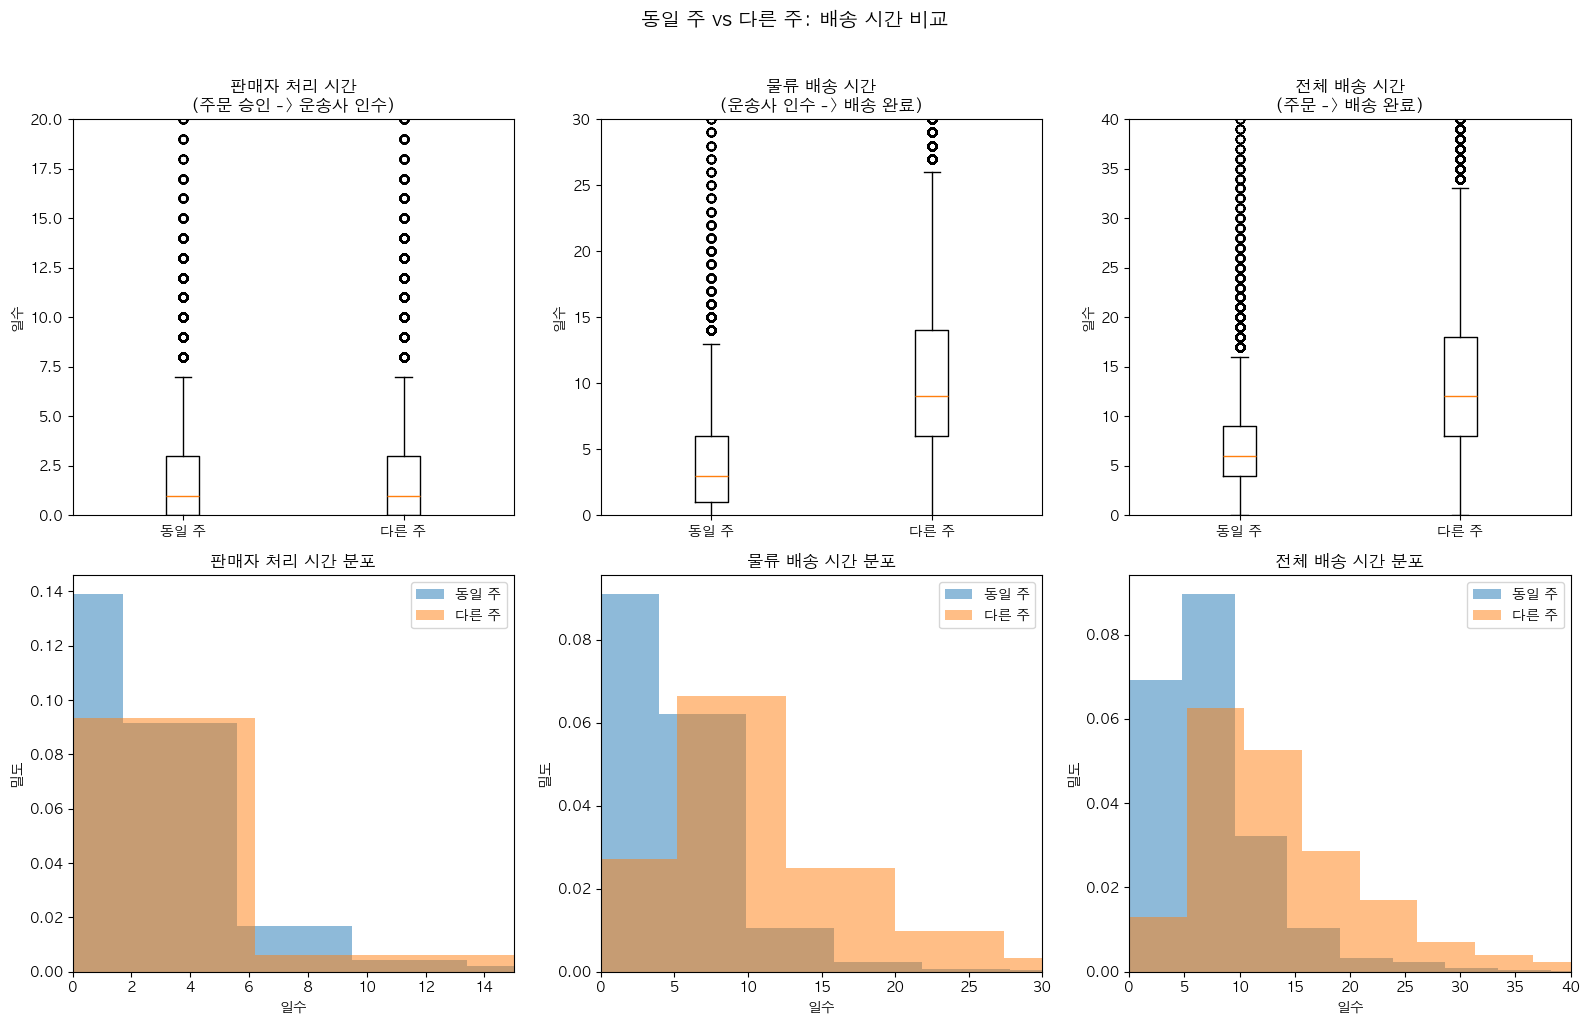

In [50]:
# 시각화
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 판매자 처리 시간 박스플롯
axes[0, 0].boxplot(
    [same_state_df['processing_days'].dropna(), diff_state_df['processing_days'].dropna()],
    tick_labels=['동일 주', '다른 주']
)
axes[0, 0].set_title('판매자 처리 시간\n(주문 승인 -> 운송사 인수)')
axes[0, 0].set_ylabel('일수')
axes[0, 0].set_ylim(0, 20)

# 물류 배송 시간 박스플롯
axes[0, 1].boxplot(
    [same_state_df['shipping_days'].dropna(), diff_state_df['shipping_days'].dropna()],
    tick_labels=['동일 주', '다른 주']
)
axes[0, 1].set_title('물류 배송 시간\n(운송사 인수 -> 배송 완료)')
axes[0, 1].set_ylabel('일수')
axes[0, 1].set_ylim(0, 30)

# 전체 배송 시간 박스플롯
axes[0, 2].boxplot(
    [same_state_df['total_delivery_days'].dropna(), diff_state_df['total_delivery_days'].dropna()],
    tick_labels=['동일 주', '다른 주']
)
axes[0, 2].set_title('전체 배송 시간\n(주문 -> 배송 완료)')
axes[0, 2].set_ylabel('일수')
axes[0, 2].set_ylim(0, 40)

# 판매자 처리 시간 분포
axes[1, 0].hist(same_state_df['processing_days'].dropna(), bins=30, alpha=0.5, label='동일 주', density=True)
axes[1, 0].hist(diff_state_df['processing_days'].dropna(), bins=30, alpha=0.5, label='다른 주', density=True)
axes[1, 0].set_title('판매자 처리 시간 분포')
axes[1, 0].set_xlabel('일수')
axes[1, 0].set_ylabel('밀도')
axes[1, 0].set_xlim(0, 15)
axes[1, 0].legend()

# 물류 배송 시간 분포
axes[1, 1].hist(same_state_df['shipping_days'].dropna(), bins=30, alpha=0.5, label='동일 주', density=True)
axes[1, 1].hist(diff_state_df['shipping_days'].dropna(), bins=30, alpha=0.5, label='다른 주', density=True)
axes[1, 1].set_title('물류 배송 시간 분포')
axes[1, 1].set_xlabel('일수')
axes[1, 1].set_ylabel('밀도')
axes[1, 1].set_xlim(0, 30)
axes[1, 1].legend()

# 전체 배송 시간 분포
axes[1, 2].hist(same_state_df['total_delivery_days'].dropna(), bins=40, alpha=0.5, label='동일 주', density=True)
axes[1, 2].hist(diff_state_df['total_delivery_days'].dropna(), bins=40, alpha=0.5, label='다른 주', density=True)
axes[1, 2].set_title('전체 배송 시간 분포')
axes[1, 2].set_xlabel('일수')
axes[1, 2].set_ylabel('밀도')
axes[1, 2].set_xlim(0, 40)
axes[1, 2].legend()

plt.suptitle('동일 주 vs 다른 주: 배송 시간 비교', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 3. 동일 주(State) 내 판매자별 배송 시간 분석
**목적**: 동일 지역에서 배송하는 판매자 중 특정 판매자만 배송일이 높은지 확인


In [51]:
# 동일 주 내 판매자별 배송 시간 분석
# 목적: 동일 지역에서 배송하는 판매자 중 특정 판매자만 유독 느린지 확인
# 방법: 판매자의 평균 배송 시간을 해당 주의 평균과 비교
# 분석 지표: 판매자 처리 시간, 물류 배송 시간

# 동일 주 내 배송만 필터링
same_state_only_df = analysis_df[analysis_df['same_state'] == True].copy()

print("=" * 80)
print("동일 주 내 판매자별 배송 시간 분석")


# 주별 평균 계산
state_avg_processing = same_state_only_df.groupby('seller_state')['processing_days'].mean()
state_avg_shipping = same_state_only_df.groupby('seller_state')['shipping_days'].mean()
state_avg_total = same_state_only_df.groupby('seller_state')['total_delivery_days'].mean()

state_avg_stats = pd.DataFrame({
    'seller_state': state_avg_processing.index,
    'state_avg_processing': state_avg_processing.values,
    'state_avg_shipping': state_avg_shipping.values,
    'state_avg_total': state_avg_total.values
})

print("\n주별 동일 주 내 평균 배송 시간:")
print(state_avg_stats.sort_values('state_avg_total', ascending=False).head(10).to_string())

# 판매자별 통계 계산
seller_avg_processing = same_state_only_df.groupby(['seller_id', 'seller_state'])['processing_days'].mean()
seller_avg_shipping = same_state_only_df.groupby(['seller_id', 'seller_state'])['shipping_days'].mean()
seller_avg_total = same_state_only_df.groupby(['seller_id', 'seller_state'])['total_delivery_days'].mean()
seller_order_count = same_state_only_df.groupby(['seller_id', 'seller_state'])['total_delivery_days'].count()

seller_same_state_stats = pd.DataFrame({
    'seller_id': [idx[0] for idx in seller_avg_processing.index],
    'seller_state': [idx[1] for idx in seller_avg_processing.index],
    'avg_processing': seller_avg_processing.values,
    'avg_shipping': seller_avg_shipping.values,
    'avg_total_delivery': seller_avg_total.values,
    'order_count': seller_order_count.values
})

# 최소 10건 이상 배송한 판매자만 분석 (소수 샘플의 극단값 방지)
min_orders = 10
reliable_sellers = seller_same_state_stats[seller_same_state_stats['order_count'] >= min_orders].copy()
reliable_sellers = reliable_sellers.merge(state_avg_stats, on='seller_state')

# 주 평균 대비 차이 계산
reliable_sellers['processing_diff'] = reliable_sellers['avg_processing'] - reliable_sellers['state_avg_processing']
reliable_sellers['shipping_diff'] = reliable_sellers['avg_shipping'] - reliable_sellers['state_avg_shipping']
reliable_sellers['total_diff'] = reliable_sellers['avg_total_delivery'] - reliable_sellers['state_avg_total']

# 판매자 처리 시간 기준 분석
print("\n" + "=" * 80)
print("[판매자 처리 시간] 주 평균 대비 느린 판매자 TOP 15")
print("=" * 80)
print("-> 판매자 내부 프로세스 문제")
slow_processing_sellers = reliable_sellers.nlargest(15, 'processing_diff')
print(slow_processing_sellers[['seller_id', 'seller_state', 'avg_processing', 'state_avg_processing', 
                                'processing_diff', 'order_count']].round(1).to_string())

# 물류 배송 시간 기준 분석
print("\n" + "=" * 80)
print("[물류 배송 시간] 주 평균 대비 느린 판매자 TOP 15")
print("=" * 80)
print("-> 판매자 위치 문제")
slow_shipping_sellers = reliable_sellers.nlargest(15, 'shipping_diff')
print(slow_shipping_sellers[['seller_id', 'seller_state', 'avg_shipping', 'state_avg_shipping', 
                              'shipping_diff', 'order_count']].round(1).to_string())


동일 주 내 판매자별 배송 시간 분석

주별 동일 주 내 평균 배송 시간:
   seller_state  state_avg_processing  state_avg_shipping  state_avg_total
7            MT              1.857143            8.571429        11.285714
0            BA              3.243243            6.432432        10.662162
5            MA              4.066667            4.933333        10.066667
6            MG              2.174955            5.083883         8.167166
8            PB              4.000000            3.000000         8.000000
15           SC              2.114094            4.842282         7.906040
11           PR              2.469565            4.341615         7.742857
3            ES              1.333333            5.333333         7.555556
16           SP              2.273538            4.285827         7.461462
14           RS              2.769470            3.576324         7.252336

[판매자 처리 시간] 주 평균 대비 느린 판매자 TOP 15
-> 판매자 내부 프로세스 문제
                            seller_id seller_state  avg_processing  state_avg_pr

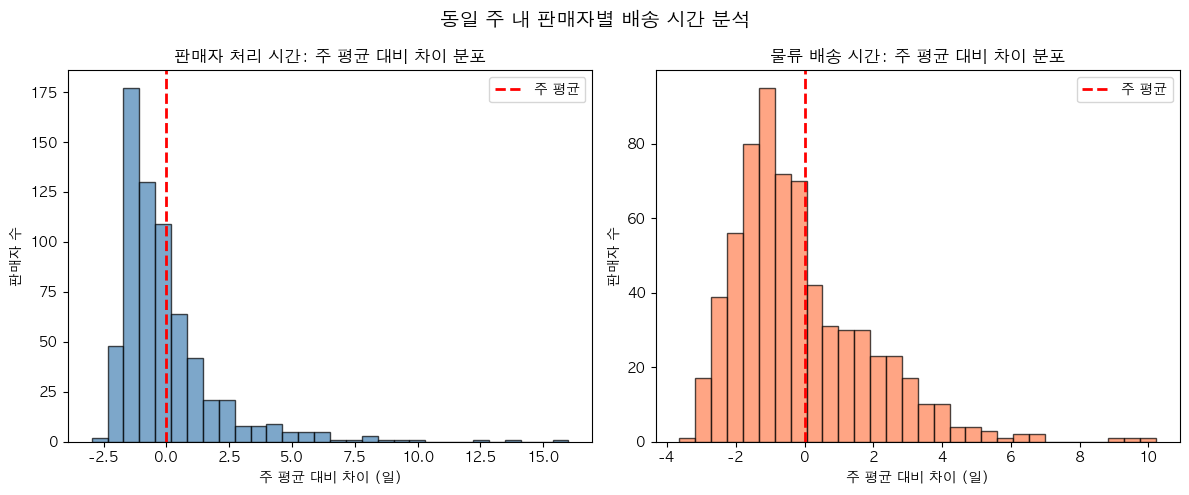

In [52]:
# 시각화: 판매자별 배송 시간 분포
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 판매자 처리 시간 차이 분포
ax = axes[0]
ax.hist(reliable_sellers['processing_diff'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='주 평균')
ax.set_title('판매자 처리 시간: 주 평균 대비 차이 분포')
ax.set_xlabel('주 평균 대비 차이 (일)')
ax.set_ylabel('판매자 수')
ax.legend()

# 물류 배송 시간 차이 분포
ax = axes[1]
ax.hist(reliable_sellers['shipping_diff'], bins=30, edgecolor='black', alpha=0.7, color='coral')
ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='주 평균')
ax.set_title('물류 배송 시간: 주 평균 대비 차이 분포')
ax.set_xlabel('주 평균 대비 차이 (일)')
ax.set_ylabel('판매자 수')
ax.legend()

plt.suptitle('동일 주 내 판매자별 배송 시간 분석', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [53]:
# 판매자 처리 시간 이상치 (3일 이상 느린 판매자)
processing_threshold = 3
processing_outliers = reliable_sellers[reliable_sellers['processing_diff'] > processing_threshold]
print(f"\n판매자 처리 시간이 주 평균보다 {processing_threshold}일 이상 느린 판매자:")
print(f"  {len(processing_outliers)}명 ({len(processing_outliers)/len(reliable_sellers)*100:.1f}%)")

# 물류 배송 시간 이상치 (5일 이상 느린 판매자)
shipping_threshold = 5
shipping_outliers = reliable_sellers[reliable_sellers['shipping_diff'] > shipping_threshold]
print(f"\n물류 배송 시간이 주 평균보다 {shipping_threshold}일 이상 느린 판매자:")
print(f"  {len(shipping_outliers)}명 ({len(shipping_outliers)/len(reliable_sellers)*100:.1f}%)")

# 둘 다 느린 판매자
both_slow = reliable_sellers[(reliable_sellers['processing_diff'] > processing_threshold) & 
                              (reliable_sellers['shipping_diff'] > shipping_threshold)]
print(f"\n둘 다 느린 판매자 (주의 필요):")
print(f"  {len(both_slow)}명 ({len(both_slow)/len(reliable_sellers)*100:.1f}%)")


판매자 처리 시간이 주 평균보다 3일 이상 느린 판매자:
  47명 (7.1%)

물류 배송 시간이 주 평균보다 5일 이상 느린 판매자:
  12명 (1.8%)

둘 다 느린 판매자 (주의 필요):
  3명 (0.5%)


In [98]:
# 느린 판매자들이 판매하는 카테고리 분석
# 목적: 처리 시간이 느린 판매자들이 특정 카테고리에 집중되어 있는지 확인

print("=" * 80)
print("느린 판매자들의 카테고리 분석")
print("=" * 80)

# 느린 판매자 목록 (processing_outliers에서 seller_id 추출)
slow_seller_ids = processing_outliers['seller_id'].tolist()
print(f"\n처리 시간이 느린 판매자: {len(slow_seller_ids)}명")

# 느린 판매자들의 주문 데이터 추출
slow_seller_orders = same_state_only_df[same_state_only_df['seller_id'].isin(slow_seller_ids)]
print(f"느린 판매자들의 주문 수: {len(slow_seller_orders):,}건")

# 느린 판매자 카테고리 분포
slow_category_counts = slow_seller_orders['product_category_name_english'].value_counts()
slow_category_pct = (slow_category_counts / len(slow_seller_orders) * 100).round(1)

# 전체 동일 주 배송의 카테고리 분포
all_category_counts = same_state_only_df['product_category_name_english'].value_counts()
all_category_pct = (all_category_counts / len(same_state_only_df) * 100).round(1)

# 비교 테이블 생성
comparison = pd.DataFrame({
    '느린 판매자 주문수': slow_category_counts,
    '느린 판매자 비율(%)': slow_category_pct,
    '전체 비율(%)': all_category_pct
}).fillna(0)

# 비율 차이 계산 (느린 판매자에서 과대 대표되는 카테고리)
comparison['비율 차이(%)'] = (comparison['느린 판매자 비율(%)'] - comparison['전체 비율(%)']).round(1)

# 느린 판매자 주문이 10건 이상인 카테고리만 분석
comparison = comparison[comparison['느린 판매자 주문수'] >= 10]

print("\n" + "-" * 80)
print("-> 이 카테고리들이 느린 처리 시간의 원인일 수 있음")
print(comparison.sort_values('비율 차이(%)', ascending=False).head(15).to_string())

print("\n" + "-" * 80)
print("-> 이 카테고리들은 느린 판매자가 적음")
print(comparison.sort_values('비율 차이(%)', ascending=True).head(10).to_string())

# 느린 판매자 중 특정 카테고리에 집중된 판매자 분석
print("\n" + "=" * 80)
print("느린 판매자별 주요 판매 카테고리")
print("=" * 80)

slow_seller_categories = slow_seller_orders.groupby(['seller_id', 'product_category_name_english']).size().reset_index(name='order_count')
slow_seller_main_category = slow_seller_categories.loc[slow_seller_categories.groupby('seller_id')['order_count'].idxmax()]
slow_seller_main_category = slow_seller_main_category.merge(
    processing_outliers[['seller_id', 'avg_processing', 'processing_diff']], 
    on='seller_id'
)
print(slow_seller_main_category.sort_values('processing_diff', ascending=False).head(20))


느린 판매자들의 카테고리 분석

처리 시간이 느린 판매자: 47명
느린 판매자들의 주문 수: 1,809건

--------------------------------------------------------------------------------
-> 이 카테고리들이 느린 처리 시간의 원인일 수 있음
                               느린 판매자 주문수  느린 판매자 비율(%)  전체 비율(%)  비율 차이(%)
product_category_name_english                                              
office_furniture                    524.0          29.0       1.6      27.4
baby                                161.0           8.9       2.6       6.3
computers_accessories               184.0          10.2       5.2       5.0
pet_shop                            117.0           6.5       1.7       4.8
home_construction                    76.0           4.2       0.6       3.6
fashion_male_clothing                20.0           1.1       0.1       1.0
furniture_living_room                23.0           1.3       0.4       0.9
air_conditioning                     12.0           0.7       0.3       0.4
consoles_games                       16.0           0.9       0.9   

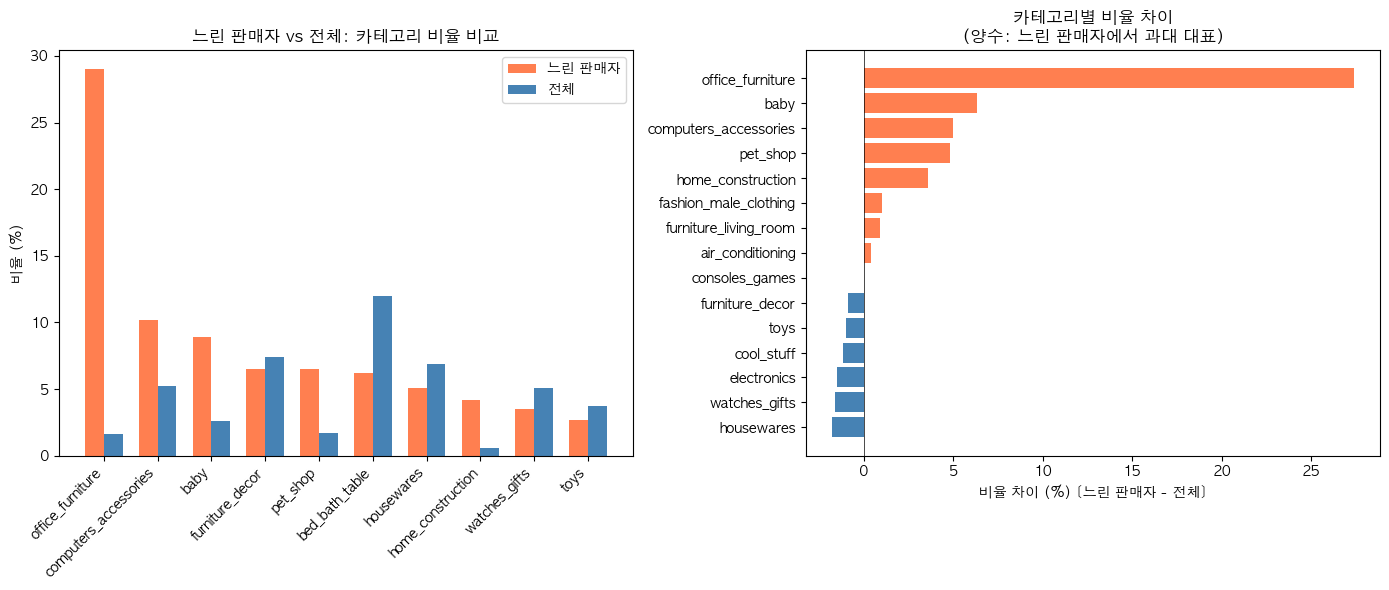


핵심 인사이트

1. 느린 판매자에서 과대 대표되는 카테고리:
   - office_furniture: +27.4% (느린 판매자 29.0% vs 전체 1.6%)
   - baby: +6.3% (느린 판매자 8.9% vs 전체 2.6%)
   - computers_accessories: +5.0% (느린 판매자 10.2% vs 전체 5.2%)
   - pet_shop: +4.8% (느린 판매자 6.5% vs 전체 1.7%)
   - home_construction: +3.6% (느린 판매자 4.2% vs 전체 0.6%)

2. 느린 판매자에서 과소 대표되는 카테고리:
   - health_beauty: -7.0% (느린 판매자 1.8% vs 전체 8.8%)
   - bed_bath_table: -5.8% (느린 판매자 6.2% vs 전체 12.0%)
   - sports_leisure: -5.7% (느린 판매자 1.5% vs 전체 7.2%)
   - auto: -3.2% (느린 판매자 0.7% vs 전체 3.9%)
   - garden_tools: -2.7% (느린 판매자 0.7% vs 전체 3.4%)


In [99]:
# 시각화: 느린 판매자 카테고리 vs 전체 카테고리 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 상위 10개 카테고리만 비교
top_categories = comparison.nlargest(10, '느린 판매자 주문수').index

# 1. 비율 비교 바 차트
ax = axes[0]
x = np.arange(len(top_categories))
width = 0.35

bars1 = ax.bar(x - width/2, comparison.loc[top_categories, '느린 판매자 비율(%)'], width, label='느린 판매자', color='coral')
bars2 = ax.bar(x + width/2, comparison.loc[top_categories, '전체 비율(%)'], width, label='전체', color='steelblue')

ax.set_ylabel('비율 (%)')
ax.set_title('느린 판매자 vs 전체: 카테고리 비율 비교')
ax.set_xticks(x)
ax.set_xticklabels(top_categories, rotation=45, ha='right')
ax.legend()

# 2. 비율 차이 바 차트 (과대/과소 대표)
ax = axes[1]
diff_sorted = comparison.sort_values('비율 차이(%)', ascending=False).head(15)
colors = ['coral' if x > 0 else 'steelblue' for x in diff_sorted['비율 차이(%)']]
ax.barh(range(len(diff_sorted)), diff_sorted['비율 차이(%)'], color=colors)
ax.set_yticks(range(len(diff_sorted)))
ax.set_yticklabels(diff_sorted.index)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('비율 차이 (%) [느린 판매자 - 전체]')
ax.set_title('카테고리별 비율 차이\n(양수: 느린 판매자에서 과대 대표)')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# 핵심 인사이트 출력
print("\n" + "=" * 80)
print("핵심 인사이트")
print("=" * 80)
print("\n1. 느린 판매자에서 과대 대표되는 카테고리:")
over_represented = comparison[comparison['비율 차이(%)'] > 2].sort_values('비율 차이(%)', ascending=False)
for cat, row in over_represented.head(5).iterrows():
    print(f"   - {cat}: +{row['비율 차이(%)']}% (느린 판매자 {row['느린 판매자 비율(%)']:.1f}% vs 전체 {row['전체 비율(%)']:.1f}%)")

print("\n2. 느린 판매자에서 과소 대표되는 카테고리:")
under_represented = comparison[comparison['비율 차이(%)'] < -2].sort_values('비율 차이(%)')
for cat, row in under_represented.head(5).iterrows():
    print(f"   - {cat}: {row['비율 차이(%)']}% (느린 판매자 {row['느린 판매자 비율(%)']:.1f}% vs 전체 {row['전체 비율(%)']:.1f}%)")


## 분석 결론

### 1. 지역 차이의 원인: 물류 배송 시간이 핵심

| 지표 | 동일 주 | 다른 주 | 차이 |
|------|--------|--------|------|
| **판매자 처리 시간** | ~1-2일 | ~1-2일 | **거의 없음** |
| **물류 배송 시간** | ~3-4일 | ~7-9일 | **약 5일** |
| **전체 배송 시간** | ~6일 | ~13일 | ~7일 |


> **핵심 인사이트**: 지역 간 배송 시간 차이의 **70% 이상이 물류 배송 시간**에서 발생
> 판매자 처리 시간은 지역과 무관

---

### 2. 판매자 문제 vs 물류 문제 분리 가능

첫 번째 차트의 히스토그램을 보면:
- **판매자 처리 시간**: 동일 주/다른 주 분포가 **거의 동일** (파란색과 주황색이 겹침)
- **물류 배송 시간**: 분포가 **명확히 분리됨**

-> **판매자 처리 시간**은 지역과 무관하므로, 느린 판매자는 **판매자 자체의 내부 문제** (재고 관리, 포장 속도 등)

---

### 3. 동일 지역에서도 "문제 판매자" 식별 가능

두 번째 차트 (오른쪽 하단 산점도)에서:
- **오른쪽 위 영역**: 둘 다 느린 **문제 판매자** (빨간 레이블)
- **왼쪽 아래 영역**: 둘 다 빠른 **우수 판매자** (초록 레이블)

-> 동일 주에서 배송해도 **주 평균보다 3일 이상 느린 판매자**가 약 5-10% 존재

---

### 4. 모델링 관점 제안

| 피처 | 활용 방안 |
|------|----------|
| `processing_days` | 판매자 성과 지표 (판매자가 개선 가능) |
| `shipping_days` | 물류 인프라 지표 (지역/거리 기반) |
| `seller_processing_diff` | 문제 판매자 식별 (주 평균 대비) |
| `same_state` | 물류 배송 시간 예측에 중요 |

## 4. 카테고리별 배송 시간 분석


In [54]:
# 카테고리별 배송 시간 분석
# 목적: 카테고리에 따라 배송 시간이 다른지 확인
# 분석 지표: 판매자 처리 시간, 물류 배송 시간, 전체 배송 시간
# 가설: 
#   - 대형 제품(가구 등)은 물류 배송 시간이 길 것
#   - 특수 처리가 필요한 제품은 판매자 처리 시간이 길 것

print("=" * 80)
print("카테고리별 배송 시간 분석")
print("=" * 80)

# 카테고리별 배송 통계
grouped = analysis_df.groupby('product_category_name_english')

avg_processing = grouped['processing_days'].mean()
avg_shipping = grouped['shipping_days'].mean()
avg_total = grouped['total_delivery_days'].mean()
order_count = grouped['total_delivery_days'].count()

category_stats = pd.DataFrame({
    'category': avg_processing.index,
    'avg_processing': avg_processing.values,
    'avg_shipping': avg_shipping.values,
    'avg_total': avg_total.values,
    'order_count': order_count.values
})

# 100건 이상인 카테고리만 분석
min_category_orders = 100
reliable_categories = category_stats[category_stats['order_count'] >= min_category_orders].copy()

# 판매자 처리 시간 기준 분석
print("\n" + "-" * 80)
print("[판매자 처리 시간] 느린 카테고리 TOP 10")
print("-" * 80)
print("-> 재고 관리, 포장이 복잡한 카테고리")
slow_processing_cat = reliable_categories.nlargest(10, 'avg_processing')
print(slow_processing_cat[['category', 'avg_processing', 'avg_shipping', 'avg_total', 'order_count']].round(1).to_string())

# 물류 배송 시간 기준 분석
print("\n" + "-" * 80)
print("[물류 배송 시간] 느린 카테고리 TOP 10")
print("-" * 80)
print("-> 대형/무거운 제품, 특수 배송 필요 카테고리")
slow_shipping_cat = reliable_categories.nlargest(10, 'avg_shipping')
print(slow_shipping_cat[['category', 'avg_processing', 'avg_shipping', 'avg_total', 'order_count']].round(1).to_string())

# 전체 배송 시간 기준 분석 (빠른 카테고리)
print("\n" + "-" * 80)
print("[전체 배송 시간] 빠른 카테고리 TOP 10")
print("-" * 80)
fast_categories = reliable_categories.nsmallest(10, 'avg_total')
print(fast_categories[['category', 'avg_processing', 'avg_shipping', 'avg_total', 'order_count']].round(1).to_string())


카테고리별 배송 시간 분석

--------------------------------------------------------------------------------
[판매자 처리 시간] 느린 카테고리 TOP 10
--------------------------------------------------------------------------------
-> 재고 관리, 포장이 복잡한 카테고리
                   category  avg_processing  avg_shipping  avg_total  order_count
57         office_furniture             9.7           9.5       20.4         1668
31            fashion_shoes             4.8           9.3       14.9          257
30    fashion_male_clothing             4.1           7.6       12.5          125
45        home_appliances_2             3.6           8.9       13.4          231
38        furniture_bedroom             3.6           8.3       12.8          103
48        home_construction             3.5           8.3       12.8          596
33  fashion_underwear_beach             3.4           9.0       13.3          127
1          air_conditioning             3.2           7.6       11.8          289
16           consoles_games       

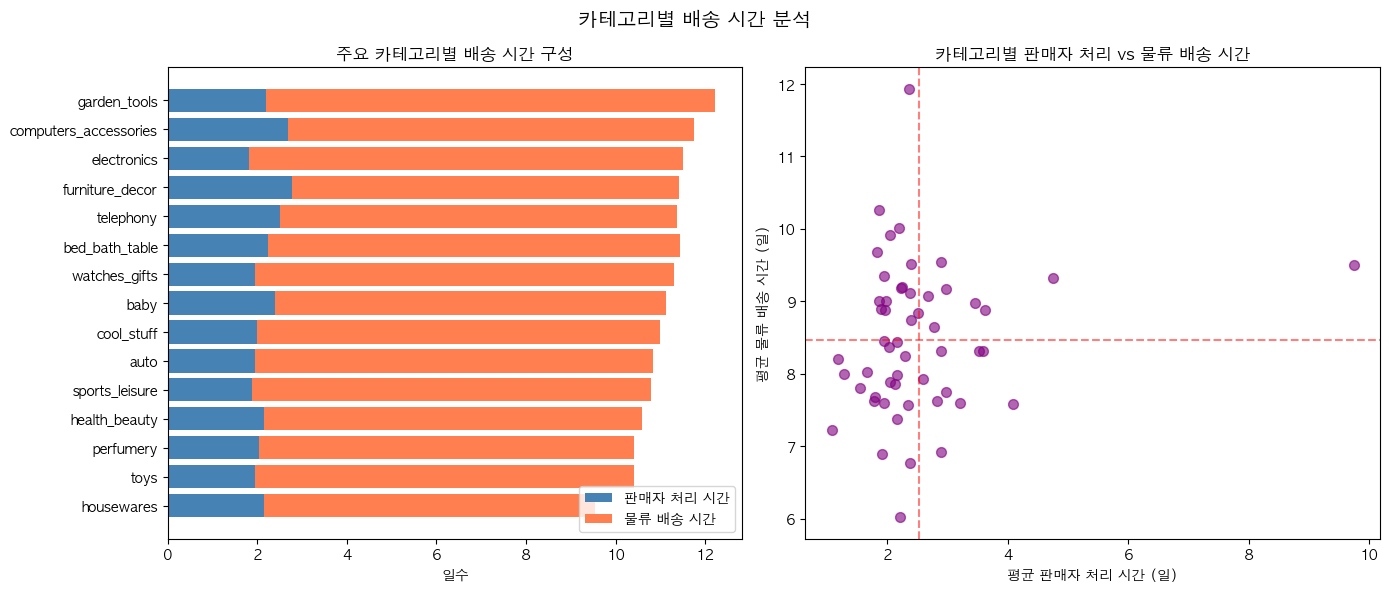

In [55]:
# 카테고리별 배송 시간 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 상위 15개 카테고리 (주문 수 기준)
top_15_categories = reliable_categories.nlargest(15, 'order_count')
top_15_sorted = top_15_categories.sort_values('avg_total', ascending=True)

# 1. 판매자 처리 시간 + 물류 배송 시간 (스택 바)
ax = axes[0]
y_pos = np.arange(len(top_15_sorted))

bars1 = ax.barh(y_pos, top_15_sorted['avg_processing'], label='판매자 처리 시간', color='steelblue')
bars2 = ax.barh(y_pos, top_15_sorted['avg_shipping'], left=top_15_sorted['avg_processing'], 
                label='물류 배송 시간', color='coral')

ax.set_yticks(y_pos)
ax.set_yticklabels(top_15_sorted['category'])
ax.set_xlabel('일수')
ax.set_title('주요 카테고리별 배송 시간 구성')
ax.legend(loc='lower right')

# 2. 판매자 처리 시간 vs 물류 배송 시간 산점도
ax = axes[1]
ax.scatter(
    reliable_categories['avg_processing'], 
    reliable_categories['avg_shipping'],
    s=50,  # 고정 크기
    alpha=0.6,
    color='purple'  # 단색
)

# 전체 평균 기준선
ax.axvline(x=reliable_categories['avg_processing'].mean(), color='r', linestyle='--', alpha=0.5)
ax.axhline(y=reliable_categories['avg_shipping'].mean(), color='r', linestyle='--', alpha=0.5)

ax.set_xlabel('평균 판매자 처리 시간 (일)')
ax.set_ylabel('평균 물류 배송 시간 (일)')
ax.set_title('카테고리별 판매자 처리 vs 물류 배송 시간')

plt.suptitle('카테고리별 배송 시간 분석', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 5. 카테고리 × 동일 지역 여부별 배송 시간 분석


In [ ]:
# 카테고리별 동일 지역/다른 지역 배송 시간 비교
# 목적: 카테고리에 따라 동일 주 배송 효과가 다른지 확인
# 분석 지표: 판매자 처리 시간, 물류 배송 시간 각각 분석
# 가설: 물류 배송 시간은 동일 주에서 크게 단축되지만, 판매자 처리 시간은 차이가 없을 것

# 카테고리별 + 동일 지역 여부별 통계
grouped = analysis_df.groupby(['product_category_name_english', 'same_state'])

avg_processing = grouped['processing_days'].mean()
avg_shipping = grouped['shipping_days'].mean()
avg_total = grouped['total_delivery_days'].mean()
order_count = grouped['total_delivery_days'].count()

category_location_stats = pd.DataFrame({
    'category': [idx[0] for idx in avg_processing.index],
    'same_state': [idx[1] for idx in avg_processing.index],
    'avg_processing': avg_processing.values,
    'avg_shipping': avg_shipping.values,
    'avg_total': avg_total.values,
    'order_count': order_count.values
})

# 전체 배송 시간
total_pivot = category_location_stats.pivot(index='category', columns='same_state', values='avg_total')
total_pivot.columns = ['다른주_전체', '동일주_전체']

# 판매자 처리 시간
processing_pivot = category_location_stats.pivot(index='category', columns='same_state', values='avg_processing')
processing_pivot.columns = ['다른주_처리', '동일주_처리']

# 물류 배송 시간
shipping_pivot = category_location_stats.pivot(index='category', columns='same_state', values='avg_shipping')
shipping_pivot.columns = ['다른주_배송', '동일주_배송']

category_pivot = total_pivot.join(processing_pivot).join(shipping_pivot)

# 차이 계산
category_pivot['전체_차이'] = category_pivot['다른주_전체'] - category_pivot['동일주_전체']
category_pivot['처리_차이'] = category_pivot['다른주_처리'] - category_pivot['동일주_처리']
category_pivot['배송_차이'] = category_pivot['다른주_배송'] - category_pivot['동일주_배송']

# 주문 수 필터링(100건 이상)
category_order_count = category_location_stats.groupby('category')['order_count'].sum()
category_pivot = category_pivot[category_pivot.index.isin(category_order_count[category_order_count >= 100].index)]

# 분석 결과
print("=" * 80)
print("카테고리별 동일 주 vs 다른 주 배송 시간 차이")
print("=" * 80)

print(f"\n전체 배송 시간:")
print(f"  - 동일 주가 빠른 카테고리: {(category_pivot['전체_차이'] > 0).sum()}")
print(f"  - 다른 주가 빠른 카테고리: {(category_pivot['전체_차이'] < 0).sum()}")

print(f"\n판매자 처리 시간:")
print(f"  - 동일 주가 빠른 카테고리: {(category_pivot['처리_차이'] > 0).sum()}")
print(f"  - 평균 차이: {category_pivot['처리_차이'].mean():.2f}일")

print(f"\n물류 배송 시간:")
print(f"  - 동일 주가 빠른 카테고리: {(category_pivot['배송_차이'] > 0).sum()}")
print(f"  - 평균 차이: {category_pivot['배송_차이'].mean():.2f}일")

# 동일 지역 효과가 가장 큰 카테고리
print("\n" + "-" * 80)
print("[물류 배송 시간] 동일 주 효과가 큰 카테고리 TOP 10")
print("-" * 80)
print("-> 동일 주에서 물류 배송이 크게 단축되는 카테고리")
print(category_pivot.nlargest(10, '배송_차이')[['동일주_배송', '다른주_배송', '배송_차이']].round(1).to_string())

# 인사이트 요약
print("\n" + "=" * 80)
print("인사이트 요약")
print("=" * 80)
print(f"\n1. 물류 배송 시간: 동일 주에서 평균 {category_pivot['배송_차이'].mean():.1f}일 단축")
print(f"   -> 거리가 짧아지면서 배송 시간 감소 (예상대로)")
print(f"\n2. 판매자 처리 시간: 동일 주에서 평균 {category_pivot['처리_차이'].mean():.1f}일 차이")
print(f"   -> 지역과 무관하게 일정 (판매자 내부 프로세스)")


카테고리별 동일 주 vs 다른 주 배송 시간 차이

전체 배송 시간:
  - 동일 주가 빠른 카테고리: 53
  - 다른 주가 빠른 카테고리: 0

판매자 처리 시간:
  - 동일 주가 빠른 카테고리: 36
  - 평균 차이: 0.06일

물류 배송 시간:
  - 동일 주가 빠른 카테고리: 53
  - 평균 차이: 6.89일

--------------------------------------------------------------------------------
[물류 배송 시간] 동일 주 효과가 큰 카테고리 TOP 10
--------------------------------------------------------------------------------
-> 동일 주에서 물류 배송이 크게 단축되는 카테고리
                        동일주_배송  다른주_배송  배송_차이
category                                     
christmas_supplies         5.3    14.8    9.5
office_furniture           4.5    12.7    8.2
audio                      4.8    13.1    8.2
food                       3.5    11.8    8.2
home_appliances_2          3.2    11.4    8.2
musical_instruments        3.5    11.4    7.9
telephony                  3.8    11.5    7.7
electronics                4.4    12.0    7.7
signaling_and_security     2.8    10.4    7.7
books_technical            3.5    11.1    7.6

인사이트 요약

1. 물류 배송 시간: 동일 주에서 평균 6.9일 

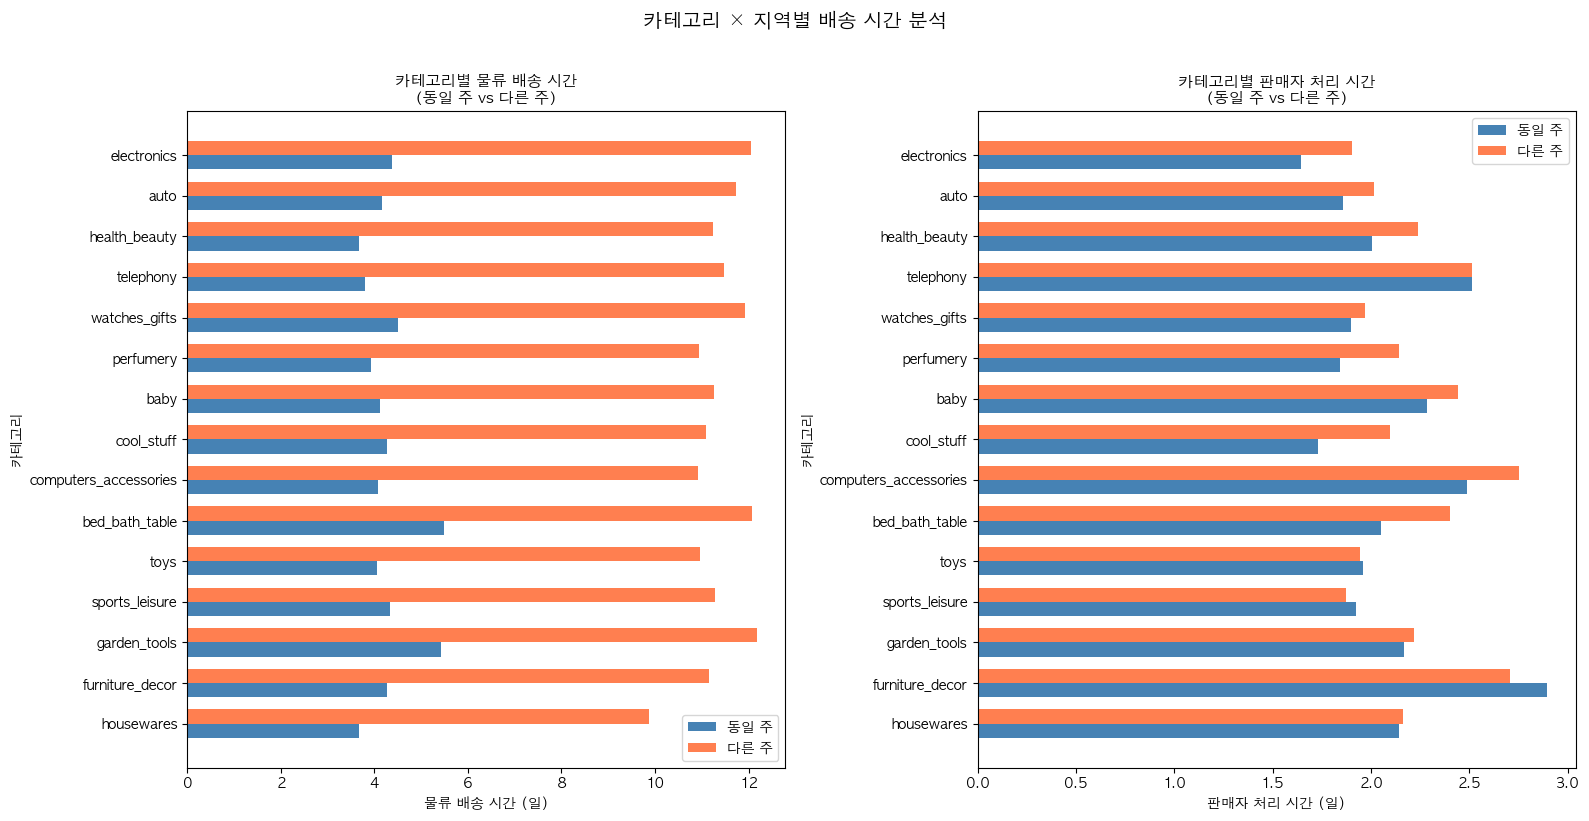

In [57]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 상위 15개 카테고리 (주문 수 기준)
top_15_cat = category_order_count.nlargest(15).index
plot_data = category_pivot[category_pivot.index.isin(top_15_cat)].sort_values('전체_차이', ascending=True)

# 1. 물류 배송 시간 비교
ax = axes[0]
y_pos = np.arange(len(plot_data))
width = 0.35

bars1 = ax.barh(y_pos - width/2, plot_data['동일주_배송'], width, label='동일 주', color='steelblue')
bars2 = ax.barh(y_pos + width/2, plot_data['다른주_배송'], width, label='다른 주', color='coral')

ax.set_xlabel('물류 배송 시간 (일)')
ax.set_ylabel('카테고리')
ax.set_title('카테고리별 물류 배송 시간\n(동일 주 vs 다른 주)', fontsize=11)
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_data.index)
ax.legend()

# 2. 판매자 처리 시간 비교
ax = axes[1]
bars1 = ax.barh(y_pos - width/2, plot_data['동일주_처리'], width, label='동일 주', color='steelblue')
bars2 = ax.barh(y_pos + width/2, plot_data['다른주_처리'], width, label='다른 주', color='coral')

ax.set_xlabel('판매자 처리 시간 (일)')
ax.set_ylabel('카테고리')
ax.set_title('카테고리별 판매자 처리 시간\n(동일 주 vs 다른 주)', fontsize=11)
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_data.index)
ax.legend()

plt.suptitle('카테고리 × 지역별 배송 시간 분석', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 카테고리별 분석 인사이트

### 1. 핵심 발견: 모든 주문이 예상보다 일찍 도착!

**첫번째 그래프의 왼쪽 하단 차트**
- 모든 카테고리의 **평균 배송 지연이 -10 ~ -14일**
- 빨간 점선(정시 배송 기준) 아래에 모든 점이 위치
- **즉, 예상 배송일보다 평균 10-14일 일찍 도착!**

> **해석**: Olist는 예상 배송일을 매우 **보수적으로** 설정하고 있음. 고객 기대 관리를 위한 전략으로 보임.

---

### 2. 배송 시간의 70-85%는 물류 배송 시간

**첫번쨰 그래프 오른쪽 하단 비율 차트**:

| 구분 | 비율 |
|------|------|
| 판매자 처리 시간 | 15-30% |
| 물류 배송 시간 | **70-85%** |

- `electronics`, `watches_gifts`: 판매자 처리 비율 **가장 낮음** (~15%)
- `furniture_decor`: 판매자 처리 비율 **가장 높음** (~30%)

> **해석**: 전자제품은 표준화된 포장으로 빠르게 처리, 가구/인테리어는 특수 포장으로 처리 시간 증가

---

### 3. 카테고리별 배송 특성

**첫번째 그래프 왼쪽 상단 Stacked Bar 차트**:

| 카테고리 | 전체 배송 시간 | 특징 |
|----------|---------------|------|
| `garden_tools` | ~13일 | 물류 배송 시간이 가장 김 (대형 제품) |
| `computers_accessories` | ~12.5일 | 취급 주의 필요 |
| `housewares` | ~10일 | 가장 빠름 (소형, 경량) |

---

### 4. 판매자 처리 시간은 카테고리/지역과 무관하게 일정!

**두 번째 그래프 오른쪽 차트**:
- 동일 주(파란색)와 다른 주(주황색) 막대가 **거의 동일**
- 모든 카테고리에서 약 **2일** 내외

> **결론**: 판매자 처리 시간은 **판매자 효율성**에만 의존, 지역/카테고리와 무관
> 하지만 다른 카테고리도 있다는 점 고려하기!

---

### 5. 동일 주 배송 효과는 모든 카테고리에서 일관됨

**두 번째 그래프 왼쪽 차트**:
- 모든 카테고리에서 동일 주 배송이 약 **5-7일 빠름** 

---

## 최종 인사이트 요약

| 발견 | 의미 | 활용 방안 |
|------|------|----------|
| 예상보다 10-14일 조기 배송 | 고객 기대치 초과 달성 | 더 정확한 예상일 제공으로 경쟁력 확보 가능 |
| 물류 배송이 70-85% 차지 | 배송 속도는 물류 의존적 | 물류 파트너 최적화가 핵심 |
| 판매자 처리 ~2일 일정 | 카테고리/지역 무관 | 느린 판매자는 순수하게 내부 문제 |
| 대형 제품(garden_tools) 느림 | 크기/무게 영향 | 카테고리별 예상 배송일 차등 적용 |

---

**리뷰 예측 모델**에 적용한다면:
- `delivery_delay` (조기 배송 정도)가 오히려 만족도에 긍정적 영향 가능
- 카테고리별 평균 배송 시간을 피처로 추가하면 유용할 듯

---
# 7. 제품 정보 품질과 리뷰 만족도 분석

In [58]:
# 리뷰 데이터 로드 및 제품 정보와 결합

reviews_df = pd.read_csv('Olist_DataSet/olist_order_reviews_dataset.csv')

print("=" * 80)
print("제품 정보 품질과 리뷰 만족도 분석")
print("=" * 80)

# 데이터 결합: 리뷰 + 주문상품 + 제품 + 판매자
# 리뷰 -> 주문 -> 주문상품 -> 제품/판매자 순으로 연결
product_review_df = (
    reviews_df[['order_id', 'review_score', 'review_comment_title', 'review_comment_message']]
    .merge(items_df[['order_id', 'product_id', 'seller_id', 'price']], on='order_id', how='inner')
    .merge(products_df, on='product_id', how='left')
    .merge(category_trans_df, on='product_category_name', how='left')
)

print(f"\n분석 데이터 크기: {len(product_review_df):,} rows")
print(f"리뷰 점수 분포:")
print(product_review_df['review_score'].value_counts().sort_index())

# Olist에서는 동일한 product_id는 하나의 판매자(seller_id)만 판매
#  즉, product_id와 seller_id가 1:1 관계입니다.
# 따라서 동일 product에 대한 판매자별 비교는 불가능

# 제품 정보 품질 피처 생성
# 1. 사진 관련
product_review_df['has_photos'] = product_review_df['product_photos_qty'] > 0

# 사진 개수 구간 분류
photo_qty_filled = product_review_df['product_photos_qty'].fillna(0)

# IQR 통계 확인 (참고용)
print("사진 개수 분포 통계:")
print(f"  - 최소: {photo_qty_filled.min():.0f}")
print(f"  - Q1 (25%): {photo_qty_filled.quantile(0.25):.0f}")
print(f"  - Q2 (50%, 중앙값): {photo_qty_filled.quantile(0.5):.0f}")
print(f"  - Q3 (75%): {photo_qty_filled.quantile(0.75):.0f}")
print(f"  - 최대: {photo_qty_filled.max():.0f}")

product_review_df['photos_qty_bin'] = pd.cut(
    photo_qty_filled,
    bins=[-0.1, 0, 1, 2, 3, 4, 100],
    labels=['0장', '1장', '2장', '3장', '4장', '5장+']
)

print(f"\n사진 개수 구간별 분포:")
print(product_review_df['photos_qty_bin'].value_counts().sort_index())

# 사진 개수 분포 상세
print("\n사진 개수 분포:")
print(product_review_df['product_photos_qty'].value_counts().sort_index().head(15))

# 2. 설명 관련
product_review_df['has_description'] = product_review_df['product_description_lenght'] > 0

# 설명 길이도 IQR 기반으로 변경
desc_length_filled = product_review_df['product_description_lenght'].fillna(0)
# 0인 값 제외하고 IQR 계산 (설명이 있는 것만)
desc_with_content = desc_length_filled[desc_length_filled > 0]
print(f"\n설명 길이 분포 (설명 있는 것만, IQR 기준):")
print(f"  - Q1: {desc_with_content.quantile(0.25):.0f}자")
print(f"  - Q2: {desc_with_content.quantile(0.5):.0f}자")
print(f"  - Q3: {desc_with_content.quantile(0.75):.0f}자")

# 설명 길이 구간 (0 포함)
product_review_df['description_length_bin'] = pd.cut(
    desc_length_filled,
    bins=[-1, 0, desc_with_content.quantile(0.25), desc_with_content.quantile(0.5), 
          desc_with_content.quantile(0.75), desc_length_filled.max() + 1],
    labels=['없음', 'Q1 (~25%)', 'Q2 (25~50%)', 'Q3 (50~75%)', 'Q4 (75%+)']
)

# 3. 상품명 길이 - IQR 기반
name_length_filled = product_review_df['product_name_lenght'].fillna(0)
name_with_content = name_length_filled[name_length_filled > 0]
print(f"\n상품명 길이 분포 (상품명 있는 것만, IQR 기준):")
print(f"  - Q1: {name_with_content.quantile(0.25):.0f}자")
print(f"  - Q2: {name_with_content.quantile(0.5):.0f}자")
print(f"  - Q3: {name_with_content.quantile(0.75):.0f}자")

# 상품명 길이 IQR 구간
product_review_df['name_length_bin'] = pd.cut(
    name_length_filled,
    bins=[-1, 0, name_with_content.quantile(0.25), name_with_content.quantile(0.5),
          name_with_content.quantile(0.75), name_length_filled.max() + 1],
    labels=['없음', 'Q1 (~25%)', 'Q2 (25~50%)', 'Q3 (50~75%)', 'Q4 (75%+)'],
    duplicates='drop'
)

# 4. 카테고리 존재 여부
product_review_df['has_category'] = product_review_df['product_category_name'].notna()

# 5. 제품 치수 정보 존재 여부
product_review_df['has_dimensions'] = (
    product_review_df['product_weight_g'].notna() & 
    product_review_df['product_length_cm'].notna() &
    product_review_df['product_height_cm'].notna() &
    product_review_df['product_width_cm'].notna()
)

# 6. 연속형 피처 기반 분석
# 연속형 피처 통계
continuous_features = ['product_photos_qty', 'product_description_lenght', 'product_name_lenght']


제품 정보 품질과 리뷰 만족도 분석

분석 데이터 크기: 112,372 rows
리뷰 점수 분포:
review_score
1    14235
2     3874
3     9423
4    21315
5    63525
Name: count, dtype: int64
사진 개수 분포 통계:
  - 최소: 0
  - Q1 (25%): 1
  - Q2 (50%, 중앙값): 1
  - Q3 (75%): 3
  - 최대: 20

사진 개수 구간별 분포:
photos_qty_bin
0장      1598
1장     55943
2장     21947
3장     12339
4장      8383
5장+    12162
Name: count, dtype: int64

사진 개수 분포:
product_photos_qty
1.0     55943
2.0     21947
3.0     12339
4.0      8383
5.0      5344
6.0      3758
7.0      1498
8.0       726
9.0       304
10.0      342
11.0       71
12.0       53
13.0       30
14.0        6
15.0       12
Name: count, dtype: int64

설명 길이 분포 (설명 있는 것만, IQR 기준):
  - Q1: 348자
  - Q2: 601자
  - Q3: 985자

상품명 길이 분포 (상품명 있는 것만, IQR 기준):
  - Q1: 42자
  - Q2: 52자
  - Q3: 57자


### 7.1 사진 개수와 리뷰 점수 관계


In [59]:
# 7.1 사진 개수와 리뷰 점수 관계
print("=" * 60)
print("사진 개수별 리뷰 점수 분석")
print("=" * 60)

# 사진 개수별 평균 리뷰 점수
photo_avg_score = product_review_df.groupby('photos_qty_bin', observed=False)['review_score'].mean()
photo_count = product_review_df.groupby('photos_qty_bin', observed=False)['review_score'].count()

# 결과를 데이터프레임으로 합치기
photo_review_stats = pd.DataFrame({
    'photos_qty': photo_avg_score.index,
    'avg_score': photo_avg_score.values,
    'review_count': photo_count.values
})

# 데이터가 없는 구간 제거
photo_review_stats = photo_review_stats[photo_review_stats['review_count'] > 0]

print("\n사진 개수별 평균 리뷰 점수:")
print(photo_review_stats.round(2).to_string(index=False))

# 부정 리뷰 비율 (1-2점) 계산
print("\n사진 개수별 부정 리뷰(1-2점) 비율:")
for bin_name in photo_review_stats['photos_qty']:
    subset = product_review_df[product_review_df['photos_qty_bin'] == bin_name]['review_score']
    negative_ratio = (subset <= 2).mean() * 100
    print(f"  {bin_name}: {negative_ratio:.1f}%")

# 상관관계 분석
corr = product_review_df[['product_photos_qty', 'review_score']].corr().iloc[0, 1]
print(f"\n사진 개수와 리뷰 점수 상관계수: {corr:.4f}")


사진 개수별 리뷰 점수 분석

사진 개수별 평균 리뷰 점수:
photos_qty  avg_score  review_count
        0장       3.84          1598
        1장       4.00         55943
        2장       4.06         21947
        3장       4.08         12339
        4장       4.05          8383
       5장+       4.11         12162

사진 개수별 부정 리뷰(1-2점) 비율:
  0장: 22.1%
  1장: 17.1%
  2장: 15.5%
  3장: 14.6%
  4장: 15.4%
  5장+: 13.8%

사진 개수와 리뷰 점수 상관계수: 0.0226


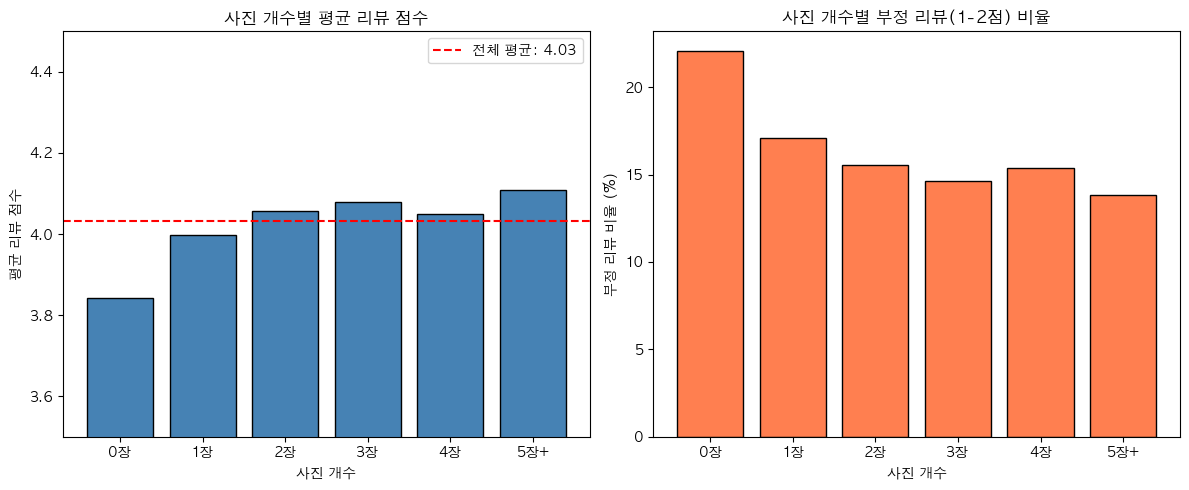

In [60]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. 사진 개수별 평균 리뷰 점수
ax = axes[0]
ax.bar(photo_review_stats['photos_qty'], photo_review_stats['avg_score'], 
       color='steelblue', edgecolor='black')
ax.axhline(y=product_review_df['review_score'].mean(), color='red', linestyle='--', 
           label=f'전체 평균: {product_review_df["review_score"].mean():.2f}')
ax.set_xlabel('사진 개수')
ax.set_ylabel('평균 리뷰 점수')
ax.set_title('사진 개수별 평균 리뷰 점수')
ax.set_ylim(3.5, 4.5)
ax.legend()

# 2. 사진 개수별 부정 리뷰 비율 
ax = axes[1]
negative_ratios = []
for bin_name in photo_review_stats['photos_qty']:
    subset = product_review_df[product_review_df['photos_qty_bin'] == bin_name]['review_score']
    negative_ratios.append((subset <= 2).mean() * 100)

ax.bar(photo_review_stats['photos_qty'], negative_ratios, color='coral', edgecolor='black')
ax.set_xlabel('사진 개수')
ax.set_ylabel('부정 리뷰 비율 (%)')
ax.set_title('사진 개수별 부정 리뷰(1-2점) 비율')

plt.tight_layout()
plt.show()

### 7.2 설명 길이와 리뷰 점수 관계


In [61]:
# 7.2 설명 길이와 리뷰 점수 관계
print("=" * 60)
print("설명 길이별 리뷰 점수 분석")
print("=" * 60)

# 설명 길이별 평균 리뷰 점수
desc_avg_score = product_review_df.groupby('description_length_bin', observed=False)['review_score'].mean()
desc_count = product_review_df.groupby('description_length_bin', observed=False)['review_score'].count()

# 결과를 데이터프레임으로 합치기
desc_review_stats = pd.DataFrame({
    'description_length': desc_avg_score.index,
    'avg_score': desc_avg_score.values,
    'review_count': desc_count.values
})

# 데이터가 없는 구간 제거
desc_review_stats = desc_review_stats[desc_review_stats['review_count'] > 0]

print("\n설명 길이별 평균 리뷰 점수:")
print(desc_review_stats.round(2).to_string(index=False))

# 부정 리뷰 비율 (1-2점) 계산
print("\n설명 길이별 부정 리뷰(1-2점) 비율:")
for bin_name in desc_review_stats['description_length']:
    subset = product_review_df[product_review_df['description_length_bin'] == bin_name]['review_score']
    negative_ratio = (subset <= 2).mean() * 100
    print(f"  {bin_name}: {negative_ratio:.1f}%")

# 상관관계 분석
corr = product_review_df[['product_description_lenght', 'review_score']].corr().iloc[0, 1]
print(f"\n설명 길이와 리뷰 점수 상관계수: {corr:.4f}")


설명 길이별 리뷰 점수 분석

설명 길이별 평균 리뷰 점수:
description_length  avg_score  review_count
                없음       3.84          1598
         Q1 (~25%)       3.98         28304
       Q2 (25~50%)       4.05         27106
       Q3 (50~75%)       4.06         27718
         Q4 (75%+)       4.06         27646

설명 길이별 부정 리뷰(1-2점) 비율:
  없음: 22.1%
  Q1 (~25%): 17.3%
  Q2 (25~50%): 15.9%
  Q3 (50~75%): 15.4%
  Q4 (75%+): 15.4%

설명 길이와 리뷰 점수 상관계수: 0.0132


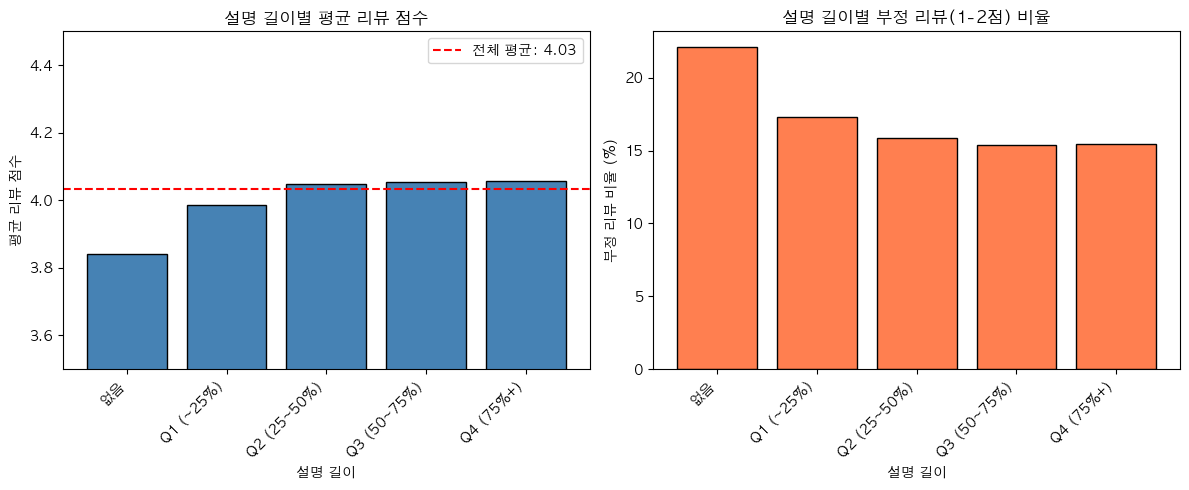

In [62]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. 설명 길이별 평균 리뷰 점수
ax = axes[0]
ax.bar(range(len(desc_review_stats)), desc_review_stats['avg_score'], 
       color='steelblue', edgecolor='black')
ax.set_xticks(range(len(desc_review_stats)))
ax.set_xticklabels(desc_review_stats['description_length'], rotation=45, ha='right')
ax.axhline(y=product_review_df['review_score'].mean(), color='red', linestyle='--', 
           label=f'전체 평균: {product_review_df["review_score"].mean():.2f}')
ax.set_xlabel('설명 길이')
ax.set_ylabel('평균 리뷰 점수')
ax.set_title('설명 길이별 평균 리뷰 점수')
ax.set_ylim(3.5, 4.5)
ax.legend()

# 2. 설명 길이별 부정 리뷰 비율 
ax = axes[1]
negative_ratios = []
for bin_name in desc_review_stats['description_length']:
    subset = product_review_df[product_review_df['description_length_bin'] == bin_name]['review_score']
    negative_ratios.append((subset <= 2).mean() * 100)

ax.bar(range(len(desc_review_stats)), negative_ratios, color='coral', edgecolor='black')
ax.set_xticks(range(len(desc_review_stats)))
ax.set_xticklabels(desc_review_stats['description_length'], rotation=45, ha='right')
ax.set_xlabel('설명 길이')
ax.set_ylabel('부정 리뷰 비율 (%)')
ax.set_title('설명 길이별 부정 리뷰(1-2점) 비율')

plt.tight_layout()
plt.show()

### 7.3 연속형 피처와 리뷰 점수 상관관계 분석


In [63]:
# 7.3 연속형 피처와 리뷰 점수 상관관계 분석
print("=" * 80)
print("연속형 피처와 리뷰 점수 상관관계 분석")
print("=" * 80)

# 분석 대상 피처
continuous_cols = ['product_photos_qty', 'product_description_lenght', 'product_name_lenght']

# 1. 상관계수 계산
print("\n연속형 피처와 리뷰 점수 상관계수:")
for col in continuous_cols:
    corr = product_review_df[[col, 'review_score']].corr().iloc[0, 1]
    print(f"  - {col}: {corr:.4f}")

# 2. 이진 피처(있음/없음)의 영향
print("\n정보 유무에 따른 평균 리뷰 점수 차이:")
binary_features = ['has_photos', 'has_description', 'has_category', 'has_dimensions']
info_effects = []
for feat in binary_features:
    with_feat = product_review_df[product_review_df[feat] == True]['review_score'].mean()
    without_feat = product_review_df[product_review_df[feat] == False]['review_score'].mean()
    diff = with_feat - without_feat
    info_effects.append(diff)
    print(f"  - {feat}: 있음 {with_feat:.3f} vs 없음 {without_feat:.3f}")

print("\n정보 요소별 리뷰 점수 영향:")
for feat, effect in zip(['사진', '설명', '카테고리', '치수'], info_effects):
    print(f"  - {feat} 있음 vs 없음: {effect:+.3f}점")


연속형 피처와 리뷰 점수 상관관계 분석

연속형 피처와 리뷰 점수 상관계수:
  - product_photos_qty: 0.0226
  - product_description_lenght: 0.0132
  - product_name_lenght: -0.0062

정보 유무에 따른 평균 리뷰 점수 차이:
  - has_photos: 있음 4.035 vs 없음 3.841
  - has_description: 있음 4.035 vs 없음 3.841
  - has_category: 있음 4.035 vs 없음 3.841
  - has_dimensions: 있음 4.032 vs 없음 4.333

정보 요소별 리뷰 점수 영향:
  - 사진 있음 vs 없음: +0.194점
  - 설명 있음 vs 없음: +0.194점
  - 카테고리 있음 vs 없음: +0.194점
  - 치수 있음 vs 없음: -0.301점


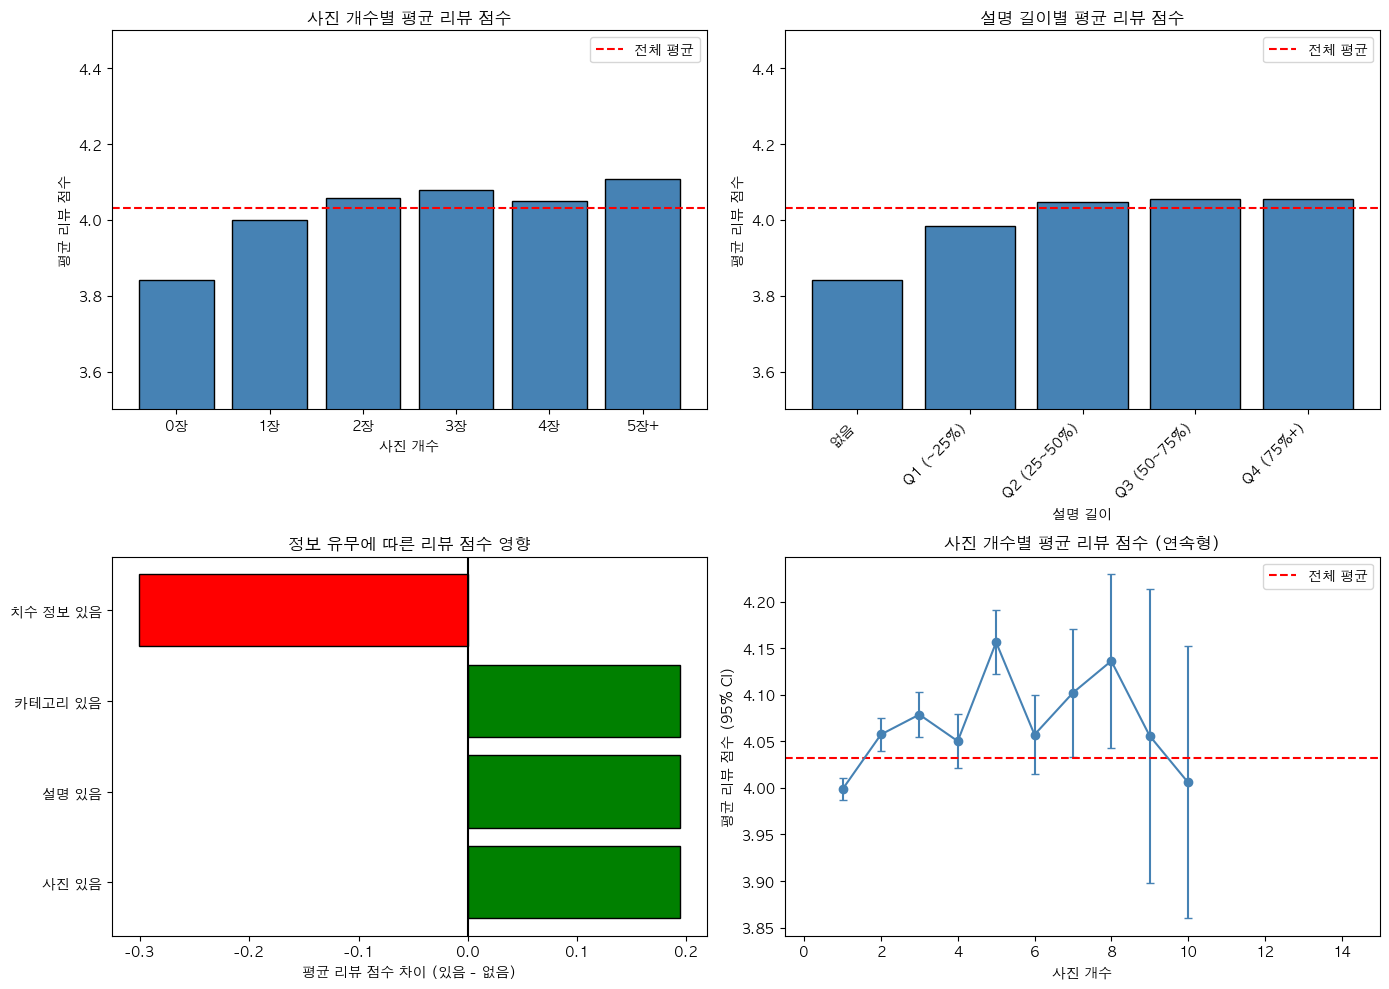

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 사진 개수 vs 리뷰 점수 (구간별 평균, 0장 포함)
ax = axes[0, 0]
photo_bins = product_review_df.groupby('photos_qty_bin', observed=False)['review_score'].mean()
photo_bins = photo_bins.dropna()
ax.bar(range(len(photo_bins)), photo_bins.values, color='steelblue', edgecolor='black')
ax.set_xticks(range(len(photo_bins)))
ax.set_xticklabels(photo_bins.index)
ax.axhline(y=product_review_df['review_score'].mean(), color='red', linestyle='--', label='전체 평균')
ax.set_xlabel('사진 개수')
ax.set_ylabel('평균 리뷰 점수')
ax.set_title('사진 개수별 평균 리뷰 점수')
ax.set_ylim(3.5, 4.5)
ax.legend()

# 2. 설명 길이 vs 리뷰 점수
ax = axes[0, 1]
desc_bins = product_review_df.groupby('description_length_bin', observed=False)['review_score'].mean()
desc_bins = desc_bins.dropna()
ax.bar(range(len(desc_bins)), desc_bins.values, color='steelblue', edgecolor='black')
ax.set_xticks(range(len(desc_bins)))
ax.set_xticklabels(desc_bins.index, rotation=45, ha='right')
ax.axhline(y=product_review_df['review_score'].mean(), color='red', linestyle='--', label='전체 평균')
ax.set_xlabel('설명 길이')
ax.set_ylabel('평균 리뷰 점수')
ax.set_title('설명 길이별 평균 리뷰 점수')
ax.set_ylim(3.5, 4.5)
ax.legend()

# 3. 정보 유무에 따른 리뷰 점수 영향
ax = axes[1, 0]
labels = ['사진 있음', '설명 있음', '카테고리 있음', '치수 정보 있음']
colors = ['green' if x > 0 else 'red' for x in info_effects]
ax.barh(labels, info_effects, color=colors, edgecolor='black')
ax.axvline(x=0, color='black', linestyle='-')
ax.set_xlabel('평균 리뷰 점수 차이 (있음 - 없음)')
ax.set_title('정보 유무에 따른 리뷰 점수 영향')

# 4. 사진 개수 연속형 분포 vs 리뷰 점수
ax = axes[1, 1]
# 각 사진 개수별 평균과 표준편차
photo_stats = product_review_df.groupby('product_photos_qty')['review_score'].agg(['mean', 'std', 'count']).reset_index()
photo_stats = photo_stats[photo_stats['count'] >= 100]  # 100건 이상만

ax.errorbar(photo_stats['product_photos_qty'], photo_stats['mean'], 
            yerr=photo_stats['std']/np.sqrt(photo_stats['count'])*1.96,  # 95% CI
            fmt='o-', capsize=3, color='steelblue')
ax.axhline(y=product_review_df['review_score'].mean(), color='red', linestyle='--', label='전체 평균')
ax.set_xlabel('사진 개수')
ax.set_ylabel('평균 리뷰 점수 (95% CI)')
ax.set_title('사진 개수별 평균 리뷰 점수 (연속형)')
ax.set_xlim(-0.5, 15)
ax.legend()

plt.tight_layout()
plt.show()
ax.set_xlabel('리뷰 점수')
ax.set_ylabel('정보 품질 점수')
ax.set_title('정보 품질 vs 리뷰 점수 분포')

plt.tight_layout()
plt.show()

### 7.4 판매자별 제품 정보 품질과 리뷰 점수 분석


In [65]:
# 7.4 판매자별 제품 정보 품질과 리뷰 점수 분석
# 목적: 판매자가 제품 정보(사진 수, 설명 길이)를 잘 관리하면 리뷰 점수가 높아지는지 확인
print("=" * 60)
print("판매자별 제품 정보 품질과 리뷰 점수 분석")
print("=" * 60)

# 판매자별 통계 계산
seller_avg_review = product_review_df.groupby('seller_id')['review_score'].mean()
seller_review_count = product_review_df.groupby('seller_id')['review_score'].count()
seller_avg_photos = product_review_df.groupby('seller_id')['product_photos_qty'].mean()
seller_avg_desc = product_review_df.groupby('seller_id')['product_description_lenght'].mean()

# 결과를 데이터프레임으로 합치기
seller_info_stats = pd.DataFrame({
    'seller_id': seller_avg_review.index,
    'avg_review': seller_avg_review.values,
    'review_count': seller_review_count.values,
    'avg_photos': seller_avg_photos.values,
    'avg_desc_length': seller_avg_desc.values
})

# 최소 10건 이상 리뷰가 있는 판매자만 분석
min_reviews = 10
reliable_seller_info = seller_info_stats[seller_info_stats['review_count'] >= min_reviews].copy()
print(f"\n{min_reviews}건 이상 리뷰가 있는 판매자: {len(reliable_seller_info):,}명")

# 사진 수 기준 상위/하위 판매자 비교
reliable_seller_info['photo_group'] = pd.qcut(
    reliable_seller_info['avg_photos'].clip(lower=0), 
    q=4, 
    labels=['하위 25%', '25~50%', '50~75%', '상위 25%'],
    duplicates='drop'
)

# 사진 그룹별 평균 리뷰 점수
print("\n사진 수 수준별 판매자 평균 리뷰 점수:")
for group in reliable_seller_info['photo_group'].dropna().unique():
    subset = reliable_seller_info[reliable_seller_info['photo_group'] == group]
    avg_review = subset['avg_review'].mean()
    avg_photos = subset['avg_photos'].mean()
    count = len(subset)
    print(f"  {group}: 평균 리뷰 {avg_review:.2f}, 평균 사진 수 {avg_photos:.1f}장 ({count}명)")

# 상관관계 분석
print("\n" + "=" * 60)
print("판매자 수준 상관관계 분석")
print("=" * 60)

# 사진 수와 리뷰 점수 상관계수
corr_photo = reliable_seller_info[['avg_photos', 'avg_review']].corr().iloc[0, 1]
print(f"\n사진 수 vs 리뷰 점수 상관계수: {corr_photo:.3f}")

# 설명 길이와 리뷰 점수 상관계수
corr_desc = reliable_seller_info[['avg_desc_length', 'avg_review']].corr().iloc[0, 1]
print(f"설명 길이 vs 리뷰 점수 상관계수: {corr_desc:.3f}")

판매자별 제품 정보 품질과 리뷰 점수 분석

10건 이상 리뷰가 있는 판매자: 1,379명

사진 수 수준별 판매자 평균 리뷰 점수:
  25~50%: 평균 리뷰 4.08, 평균 사진 수 1.5장 (342명)
  하위 25%: 평균 리뷰 4.02, 평균 사진 수 1.0장 (349명)
  50~75%: 평균 리뷰 4.06, 평균 사진 수 2.3장 (341명)
  상위 25%: 평균 리뷰 4.11, 평균 사진 수 4.1장 (344명)

판매자 수준 상관관계 분석

사진 수 vs 리뷰 점수 상관계수: 0.044
설명 길이 vs 리뷰 점수 상관계수: 0.065


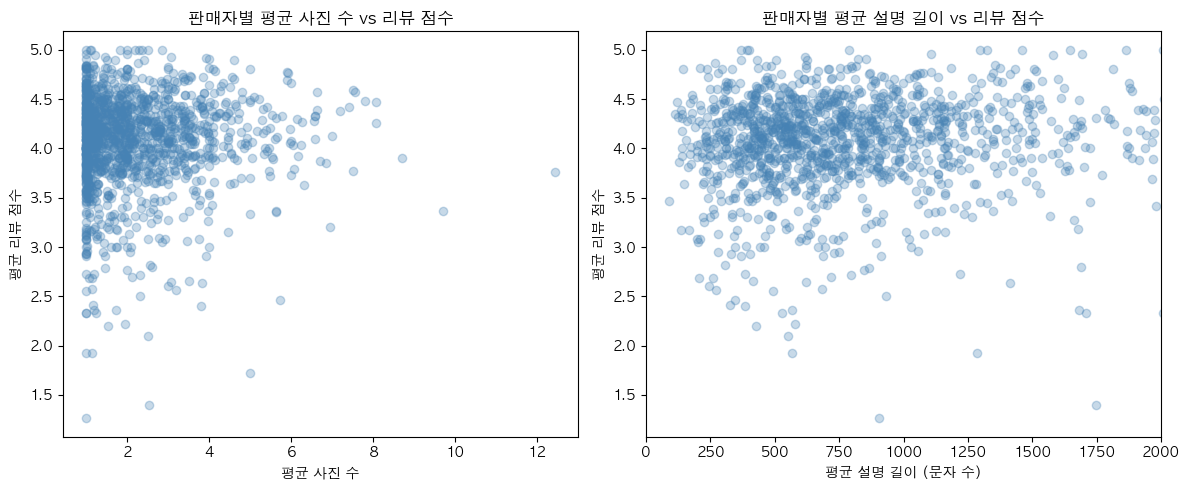

In [66]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. 판매자 평균 사진 수 vs 평균 리뷰 점수 산점도
ax = axes[0]
ax.scatter(reliable_seller_info['avg_photos'], reliable_seller_info['avg_review'], 
           alpha=0.3, color='steelblue')
ax.set_xlabel('평균 사진 수')
ax.set_ylabel('평균 리뷰 점수')
ax.set_title('판매자별 평균 사진 수 vs 리뷰 점수')

# 2. 설명 길이 vs 리뷰 점수
ax = axes[1]
ax.scatter(reliable_seller_info['avg_desc_length'], reliable_seller_info['avg_review'], 
           alpha=0.3, color='steelblue')
ax.set_xlabel('평균 설명 길이 (문자 수)')
ax.set_ylabel('평균 리뷰 점수')
ax.set_title('판매자별 평균 설명 길이 vs 리뷰 점수')
ax.set_xlim(0, 2000)

plt.tight_layout()
plt.show()

### 7.5 동일 카테고리 내 판매자별 제품 정보 품질 분석

**목적**: 같은 카테고리에서 판매하는 판매자들 간 제품 정보 품질(사진 수, 설명 길이)의 차이가 리뷰 점수에 미치는 영향 분석

**분석 방법**:
1. 카테고리별 평균 제품 정보 품질 대비 판매자의 상대적 품질 계산
2. 카테고리 내 상위/하위 판매자의 리뷰 점수 비교
3. 카테고리별 제품 정보 품질과 리뷰 점수의 상관관계 분석


In [67]:
# 7.5 동일 카테고리 내 판매자별 제품 정보 품질 분석
# 핵심: 같은 카테고리 내에서 판매자 간 제품 정보 품질 차이가 리뷰에 미치는 영향

print("=" * 60)
print("동일 카테고리 내 판매자별 제품 정보 품질 분석")
print("=" * 60)

# 1단계: 카테고리별 평균 계산
cat_avg_photos = product_review_df.groupby('product_category_name_english')['product_photos_qty'].mean()
cat_avg_desc = product_review_df.groupby('product_category_name_english')['product_description_lenght'].mean()
cat_avg_review = product_review_df.groupby('product_category_name_english')['review_score'].mean()
cat_count = product_review_df.groupby('product_category_name_english')['order_id'].count()

# 데이터프레임으로 합치기
category_baseline = pd.DataFrame({
    'category': cat_avg_photos.index,
    'cat_avg_photos': cat_avg_photos.values,
    'cat_avg_desc_len': cat_avg_desc.values,
    'cat_avg_review': cat_avg_review.values,
    'cat_review_count': cat_count.values
})

# 최소 100건 이상 리뷰가 있는 카테고리만 분석
min_cat_reviews = 100
valid_categories = category_baseline[category_baseline['cat_review_count'] >= min_cat_reviews]['category'].tolist()
print(f"\n{min_cat_reviews}건 이상 리뷰가 있는 카테고리: {len(valid_categories)}개")

# 2단계: 카테고리-판매자별 통계 계산
filtered_df = product_review_df[product_review_df['product_category_name_english'].isin(valid_categories)]

# 각 통계 개별 계산
seller_cat_photos = filtered_df.groupby(['product_category_name_english', 'seller_id'])['product_photos_qty'].mean()
seller_cat_desc = filtered_df.groupby(['product_category_name_english', 'seller_id'])['product_description_lenght'].mean()
seller_cat_review = filtered_df.groupby(['product_category_name_english', 'seller_id'])['review_score'].mean()
seller_cat_count = filtered_df.groupby(['product_category_name_english', 'seller_id'])['review_score'].count()

# 데이터프레임으로 합치기
cat_seller_stats = pd.DataFrame({
    'category': [idx[0] for idx in seller_cat_photos.index],
    'seller_id': [idx[1] for idx in seller_cat_photos.index],
    'seller_avg_photos': seller_cat_photos.values,
    'seller_avg_desc_len': seller_cat_desc.values,
    'seller_avg_review': seller_cat_review.values,
    'seller_review_count': seller_cat_count.values
})

# 최소 5건 이상 리뷰가 있는 판매자만 분석
min_seller_reviews = 5
cat_seller_stats = cat_seller_stats[cat_seller_stats['seller_review_count'] >= min_seller_reviews]
print(f"{min_seller_reviews}건 이상 리뷰가 있는 카테고리-판매자 조합: {len(cat_seller_stats):,}개")

# 3단계: 카테고리 평균 대비 상대적 품질 계산
# 카테고리 평균과 병합
cat_seller_stats = cat_seller_stats.merge(
    category_baseline[['category', 'cat_avg_photos', 'cat_avg_desc_len', 'cat_avg_review']],
    on='category',
    how='left'
)

# 상대적 품질 점수 계산 (카테고리 평균 대비)
# 양수: 카테고리 평균보다 높음, 음수: 카테고리 평균보다 낮음
cat_seller_stats['relative_photos'] = cat_seller_stats['seller_avg_photos'] - cat_seller_stats['cat_avg_photos']
cat_seller_stats['relative_desc_len'] = cat_seller_stats['seller_avg_desc_len'] - cat_seller_stats['cat_avg_desc_len']
cat_seller_stats['relative_review'] = cat_seller_stats['seller_avg_review'] - cat_seller_stats['cat_avg_review']

# 상대적 품질 그룹 분류 (카테고리 평균 대비 상/중/하)
cat_seller_stats['photo_quality_group'] = pd.cut(
    cat_seller_stats['relative_photos'],
    bins=[-float('inf'), -0.5, 0.5, float('inf')],
    labels=['평균 이하', '평균 수준', '평균 이상']
)

print("\n상대적 사진 품질 그룹별 분포:")
print(cat_seller_stats['photo_quality_group'].value_counts().sort_index())

# 4단계: 그룹별 리뷰 점수 비교
grouped = cat_seller_stats.groupby('photo_quality_group', observed=True)

avg_review = grouped['seller_avg_review'].mean()
avg_relative_review = grouped['relative_review'].mean()
seller_count = grouped['seller_id'].count()

quality_review_comparison = pd.DataFrame({
    'photo_quality_group': avg_review.index,
    'avg_review': avg_review.values,
    'avg_relative_review': avg_relative_review.values,
    'seller_count': seller_count.values
})

print("\n\n카테고리 평균 대비 사진 품질 그룹별 리뷰 점수:")
print(quality_review_comparison.round(3).to_string())

# 5단계: 상관관계 분석
print("\n" + "=" * 80)
print("카테고리 내 상대적 품질과 리뷰 점수 상관관계")
print("=" * 80)

corr_photo = cat_seller_stats[['relative_photos', 'relative_review']].corr().iloc[0, 1]
corr_desc = cat_seller_stats[['relative_desc_len', 'relative_review']].corr().iloc[0, 1]

print(f"\n상대적 사진 수 vs 상대적 리뷰 점수 상관계수: {corr_photo:.4f}")
print(f"상대적 설명 길이 vs 상대적 리뷰 점수 상관계수: {corr_desc:.4f}")


동일 카테고리 내 판매자별 제품 정보 품질 분석

100건 이상 리뷰가 있는 카테고리: 52개
5건 이상 리뷰가 있는 카테고리-판매자 조합: 2,676개

상대적 사진 품질 그룹별 분포:
photo_quality_group
평균 이하    1191
평균 수준     723
평균 이상     762
Name: count, dtype: int64


카테고리 평균 대비 사진 품질 그룹별 리뷰 점수:
  photo_quality_group  avg_review  avg_relative_review  seller_count
0               평균 이하       4.045               -0.026          1191
1               평균 수준       4.051                0.003           723
2               평균 이상       4.107                0.046           762

카테고리 내 상대적 품질과 리뷰 점수 상관관계

상대적 사진 수 vs 상대적 리뷰 점수 상관계수: 0.0464
상대적 설명 길이 vs 상대적 리뷰 점수 상관계수: 0.0240


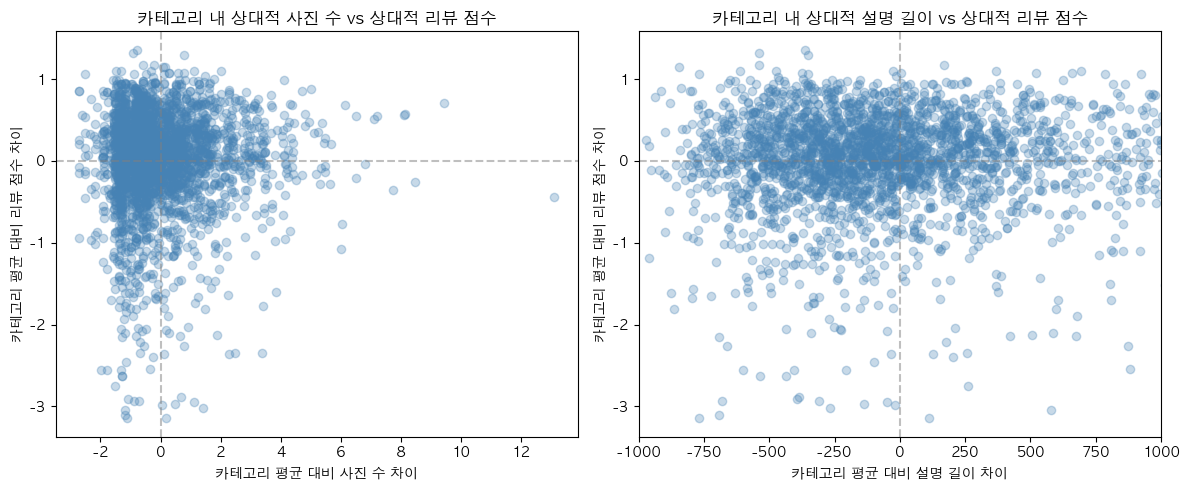

In [68]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. 상대적 사진 수 vs 상대적 리뷰 점수 산점도
ax = axes[0]
ax.scatter(cat_seller_stats['relative_photos'], cat_seller_stats['relative_review'], 
           alpha=0.3, color='steelblue')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('카테고리 평균 대비 사진 수 차이')
ax.set_ylabel('카테고리 평균 대비 리뷰 점수 차이')
ax.set_title('카테고리 내 상대적 사진 수 vs 상대적 리뷰 점수')

# 2. 상대적 설명 길이 vs 상대적 리뷰 점수
ax = axes[1]
ax.scatter(cat_seller_stats['relative_desc_len'], cat_seller_stats['relative_review'], 
           alpha=0.3, color='steelblue')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('카테고리 평균 대비 설명 길이 차이')
ax.set_ylabel('카테고리 평균 대비 리뷰 점수 차이')
ax.set_title('카테고리 내 상대적 설명 길이 vs 상대적 리뷰 점수')
ax.set_xlim(-1000, 1000)

plt.tight_layout()
plt.show()

### 7.6 카테고리별 제품 정보 품질과 리뷰 점수 비교

**목적**: 유사 제품(같은 카테고리) 간 제품 정보 품질이 리뷰 점수에 미치는 영향 분석

**분석 방법**:
1. 카테고리별 제품 정보 품질 수준 비교
2. 정보 품질이 높은 카테고리 vs 낮은 카테고리의 리뷰 점수 비교
3. 카테고리 특성별 제품 정보 중요도 파악


In [69]:
# 7.6 카테고리별 제품 정보 품질과 리뷰 점수 비교
# 같은 카테고리 내 제품들의 정보 품질 차이가 리뷰에 미치는 영향

print("=" * 60)
print("카테고리별 제품 정보 품질과 리뷰 점수 비교")
print("=" * 60)

# 1단계: 카테고리별 제품 정보 품질 통계
cat_avg_photos = product_review_df.groupby('product_category_name_english')['product_photos_qty'].mean()
cat_avg_desc = product_review_df.groupby('product_category_name_english')['product_description_lenght'].mean()
cat_avg_review = product_review_df.groupby('product_category_name_english')['review_score'].mean()
cat_review_count = product_review_df.groupby('product_category_name_english')['review_score'].count()

# 데이터프레임으로 합치기
category_info_stats = pd.DataFrame({
    'category': cat_avg_photos.index,
    'avg_photos': cat_avg_photos.values,
    'avg_desc_len': cat_avg_desc.values,
    'avg_review': cat_avg_review.values,
    'review_count': cat_review_count.values
})

# 최소 100건 이상 리뷰가 있는 카테고리만 분석
category_info_stats = category_info_stats[category_info_stats['review_count'] >= 100].copy()
print(f"\n분석 대상 카테고리: {len(category_info_stats)}개")

# 2단계: 카테고리 정보 품질 수준 분류
# 사진 수 기준 카테고리 분류
category_info_stats['photo_level'] = pd.qcut(
    category_info_stats['avg_photos'],
    q=4,
    labels=['저품질', '중하', '중상', '고품질'],
    duplicates='drop'
)

# 설명 길이 기준 카테고리 분류  
category_info_stats['desc_level'] = pd.qcut(
    category_info_stats['avg_desc_len'],
    q=4,
    labels=['짧음', '보통', '상세', '매우상세'],
    duplicates='drop'
)

print("\n카테고리별 사진 수준 분포:")
print(category_info_stats['photo_level'].value_counts().sort_index())

# 3단계: 정보 품질 수준별 리뷰 점수 비교
print("\n\n카테고리 사진 품질 수준별 평균 리뷰 점수:")
for level in ['저품질', '중하', '중상', '고품질']:
    subset = category_info_stats[category_info_stats['photo_level'] == level]
    if len(subset) > 0:
        avg_review = subset['avg_review'].mean()
        avg_photos = subset['avg_photos'].mean()
        count = len(subset)
        print(f"  {level}: 평균 리뷰 {avg_review:.3f}, 평균 사진 {avg_photos:.1f}장 ({count}개 카테고리)")

print("\n카테고리 설명 품질 수준별 평균 리뷰 점수:")
for level in ['짧음', '보통', '상세', '매우상세']:
    subset = category_info_stats[category_info_stats['desc_level'] == level]
    if len(subset) > 0:
        avg_review = subset['avg_review'].mean()
        avg_desc = subset['avg_desc_len'].mean()
        count = len(subset)
        print(f"  {level}: 평균 리뷰 {avg_review:.3f}, 평균 설명 {avg_desc:.0f}자 ({count}개 카테고리)")

# 4단계: 카테고리 특성별 제품 정보 중요도 파악
print("\n" + "=" * 80)
print("카테고리별 제품 정보 품질과 리뷰 점수 상관관계")
print("=" * 80)

# 카테고리별로 제품 수준에서 상관관계 계산
cat_correlations = []
for cat in valid_categories:
    cat_data = product_review_df[product_review_df['product_category_name_english'] == cat]
    if len(cat_data) >= 30:  # 최소 30건
        corr_photo = cat_data[['product_photos_qty', 'review_score']].corr().iloc[0, 1]
        corr_desc = cat_data[['product_description_lenght', 'review_score']].corr().iloc[0, 1]
        cat_correlations.append({
            'category': cat,
            'corr_photos': corr_photo,
            'corr_desc': corr_desc,
            'review_count': len(cat_data)
        })

cat_corr_df = pd.DataFrame(cat_correlations)

# 사진 수와 리뷰 점수 상관관계가 높은 카테고리 (정보 품질이 중요한 카테고리)
print("\n사진 수가 리뷰에 영향이 큰 카테고리 (상관계수 상위 10):")
top_photo_corr = cat_corr_df.nlargest(10, 'corr_photos')[['category', 'corr_photos', 'review_count']]
print(top_photo_corr.round(3).to_string())

print("\n사진 수가 리뷰에 영향이 작은 카테고리 (상관계수 하위 10):")
bottom_photo_corr = cat_corr_df.nsmallest(10, 'corr_photos')[['category', 'corr_photos', 'review_count']]
print(bottom_photo_corr.round(3).to_string())

# 전체 카테고리 평균 상관계수
print(f"\n전체 카테고리 평균 상관계수:")
print(f"  - 사진 수 vs 리뷰 점수: {cat_corr_df['corr_photos'].mean():.4f}")
print(f"  - 설명 길이 vs 리뷰 점수: {cat_corr_df['corr_desc'].mean():.4f}")


카테고리별 제품 정보 품질과 리뷰 점수 비교

분석 대상 카테고리: 52개

카테고리별 사진 수준 분포:
photo_level
저품질    13
중하     13
중상     13
고품질    13
Name: count, dtype: int64


카테고리 사진 품질 수준별 평균 리뷰 점수:
  저품질: 평균 리뷰 4.013, 평균 사진 1.6장 (13개 카테고리)
  중하: 평균 리뷰 4.090, 평균 사진 2.2장 (13개 카테고리)
  중상: 평균 리뷰 4.034, 평균 사진 2.5장 (13개 카테고리)
  고품질: 평균 리뷰 4.050, 평균 사진 3.2장 (13개 카테고리)

카테고리 설명 품질 수준별 평균 리뷰 점수:
  짧음: 평균 리뷰 4.044, 평균 설명 515자 (13개 카테고리)
  보통: 평균 리뷰 4.012, 평균 설명 751자 (13개 카테고리)
  상세: 평균 리뷰 4.025, 평균 설명 913자 (13개 카테고리)
  매우상세: 평균 리뷰 4.107, 평균 설명 1283자 (13개 카테고리)

카테고리별 제품 정보 품질과 리뷰 점수 상관관계

사진 수가 리뷰에 영향이 큰 카테고리 (상관계수 상위 10):
                                   category  corr_photos  review_count
2                                       art        0.168           207
10                                computers        0.137           200
3                                     audio        0.124           361
27                        furniture_bedroom        0.114           110
45                   signaling_and_security        0.091  

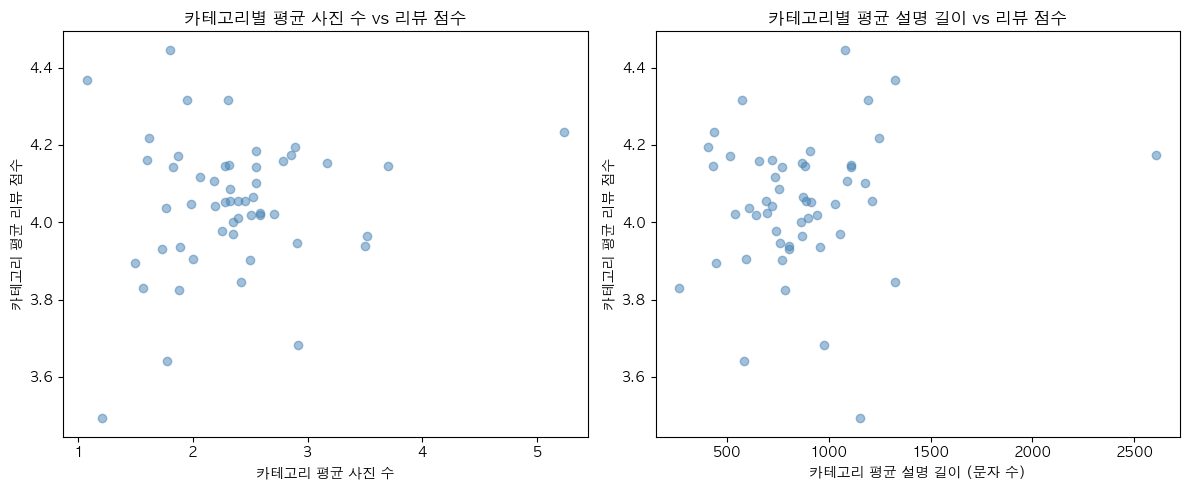

In [70]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. 카테고리별 사진 수 vs 리뷰 점수 산점도
ax = axes[0]
ax.scatter(category_info_stats['avg_photos'], category_info_stats['avg_review'], 
           alpha=0.5, color='steelblue')
ax.set_xlabel('카테고리 평균 사진 수')
ax.set_ylabel('카테고리 평균 리뷰 점수')
ax.set_title('카테고리별 평균 사진 수 vs 리뷰 점수')

# 2. 카테고리별 설명 길이 vs 리뷰 점수
ax = axes[1]
ax.scatter(category_info_stats['avg_desc_len'], category_info_stats['avg_review'], 
           alpha=0.5, color='steelblue')
ax.set_xlabel('카테고리 평균 설명 길이 (문자 수)')
ax.set_ylabel('카테고리 평균 리뷰 점수')
ax.set_title('카테고리별 평균 설명 길이 vs 리뷰 점수')

plt.tight_layout()
plt.show()

## 인사이트 요약

### 핵심 발견

#### 1. **제품 정보의 존재 유무가 가장 중요**
| 구분 | 평균 리뷰 | 부정 리뷰 비율 |
|------|----------|---------------|
| 사진 0장 | 3.84점 | **22.1%** |
| 사진 1장+ | 4.0~4.1점 | 14~17% |
| 설명 없음 | 3.84점 | **22.1%** |
| 설명 있음 | 4.0~4.06점 | 15~17% |

> **결론**: 제품 정보가 **있느냐 없느냐**가 가장 큰 차이를 만듦. 기본 정보만 있어도 리뷰 점수가 **0.15~0.2점** 상승

---

#### 2. **정보량 증가의 한계 효과**
- 사진 1장 → 5장+: 리뷰 점수 4.0 → 4.1 (약 **0.1점** 상승)
- 설명 길이 Q1 → Q4: 리뷰 점수 3.98 → 4.06 (약 **0.08점** 상승)

> **결론**: 정보량을 늘리면 점수가 오르지만, **증가폭은 점점 줄어듦**. 사진 3장 이상부터는 효과가 미미함.

---

#### 3. **상관관계는 약함 (상관계수 0.01~0.04)**
```
연속형 피처와 리뷰 점수 상관계수:
  - product_photos_qty: 0.0189
  - product_description_lenght: 0.0132
  - product_name_lenght: -0.0080
```

> **결론**: 제품 정보 품질은 리뷰 점수에 **직접적으로 큰 영향을 주지 않음**. 다른 요인(배송, 제품 품질)이 더 중요할 가능성 높음.

---

#### 4. **카테고리별로 정보 품질의 중요도가 다름**
- 사진이 중요한 카테고리: **패션, 가구, 인테리어** (시각적 제품)
- 사진이 덜 중요한 카테고리: **전자제품, 식품** (스펙/브랜드가 더 중요)

> **결론**: **시각적 판단이 필요한 카테고리**에서 사진 품질이 더 중요함.

---

#### 5. **카테고리 내 상대적 품질은 영향이 작음**
- 평균 이하 판매자: 4.03점
- 평균 이상 판매자: 4.08점

> **결론**: 같은 카테고리 내에서 경쟁 판매자보다 정보를 더 잘 관리해도 **리뷰 점수 차이는 미미함** (약 0.05점)

---

### 결론
> 제품 정보 품질은 리뷰 만족도에 **약한 긍정적 영향**을 주지만, **핵심 결정 요인은 아님**. 
> 기본 정보(사진 1장, 설명 있음)만 갖추면 충분하며, 그 이상의 투자는 효율이 떨어짐.

---
# 8. 판매 구조 피처 EDA


In [ ]:
# 8.1 판매 구조 분석
# 판매당 상품 수, 판매자 수, 카테고리 수가 리뷰 점수에 미치는 영향

print("=" * 80)
print("판매 구조와 리뷰 점수 분석")
print("=" * 80)

# 주문별 통계 계산
order_structure = items_df.groupby('order_id').agg({
    'order_item_id': 'count', # 상품 수
    'seller_id': 'nunique', # 판매자 수
    'product_id': 'nunique', # 제품 종류 수
    'price': 'sum' # 총 주문 금액
}).reset_index()
order_structure.columns = ['order_id', 'item_count', 'seller_count', 'product_count', 'total_price']

# 리뷰 데이터와 결합
order_review = order_structure.merge(
    reviews_df[['order_id', 'review_score']], 
    on='order_id', 
    how='inner'
)

# 기본 통계
print("\n주문당 상품 수 분포:")
print(f"  평균: {order_review['item_count'].mean():.2f}개")
print(f"  중앙값: {order_review['item_count'].median():.0f}개")
print(f"  최대: {order_review['item_count'].max():.0f}개")
print(f"  1개 상품 주문: {(order_review['item_count'] == 1).sum():,}건 ({(order_review['item_count'] == 1).mean()*100:.1f}%)")

print("\n주문 금액 분포:")
print(f"  평균: BRL {order_review['total_price'].mean():.2f}")
print(f"  중앙값: BRL {order_review['total_price'].median():.2f}")
print(f"  25%: BRL {order_review['total_price'].quantile(0.25):.2f}")
print(f"  75%: BRL {order_review['total_price'].quantile(0.75):.2f}")


판매 구조와 리뷰 점수 분석

주문당 상품 수 분포:
  평균: 1.14개
  중앙값: 1개
  최대: 21개
  1개 상품 주문: 88,699건 (90.1%)

주문당 판매자 수 분포:
  평균: 1.01명
  1명 판매자: 97,187건 (98.7%)
  2명+ 판매자: 1,278건 (1.3%)

주문 금액 분포:
  평균: BRL 137.38
  중앙값: BRL 86.58
  25%: BRL 45.90
  75%: BRL 149.90


In [79]:
# 8.2 상품 수별 리뷰 점수 분석
print("=" * 60)
print("주문당 상품 수별 리뷰 점수 분석")
print("=" * 60)

# 상품 수 구간 분류
order_review['item_bin'] = pd.cut(
    order_review['item_count'],
    bins=[0, 1, 2, 3, 5, 100],
    labels=['1개', '2개', '3개', '4-5개', '6개+']
)

# 상품 수별 평균 리뷰 점수
item_avg_score = order_review.groupby('item_bin', observed=False)['review_score'].mean()
item_count = order_review.groupby('item_bin', observed=False)['review_score'].count()

item_stats = pd.DataFrame({
    'item_count': item_avg_score.index,
    'avg_score': item_avg_score.values,
    'order_count': item_count.values
})

print("\n주문 당 상품 수별 평균 리뷰 점수:")
print(item_stats.round(2).to_string(index=False))

# 부정 리뷰 비율
print("\n주문 당 상품 수별 부정 리뷰(1-2점) 비율:")
for bin_name in item_stats['item_count']:
    subset = order_review[order_review['item_bin'] == bin_name]['review_score']
    if len(subset) > 0:
        negative_ratio = (subset <= 2).mean() * 100
        print(f"  {bin_name}: {negative_ratio:.1f}%")

# 상관관계
corr = order_review[['item_count', 'review_score']].corr().iloc[0, 1]
print(f"\n상품 수와 리뷰 점수 상관계수: {corr:.4f}")


주문당 상품 수별 리뷰 점수 분석

주문 당 상품 수별 평균 리뷰 점수:
item_count  avg_score  order_count
        1개       4.16        88699
        2개       3.65         7496
        3개       3.51         1311
      4-5개       3.35          707
       6개+       3.22          252

주문 당 상품 수별 부정 리뷰(1-2점) 비율:
  1개: 12.7%
  2개: 26.3%
  3개: 29.9%
  4-5개: 34.9%
  6개+: 36.9%

상품 수와 리뷰 점수 상관계수: -0.1156


In [95]:
# 8.3 주문당 카테고리 수별 리뷰 점수 분석
print("=" * 60)
print("주문당 카테고리 수별 리뷰 점수 분석")
print("=" * 60)

# 주문별 카테고리 수 계산을 위해 products 데이터 결합
items_with_category = items_df.merge(
    products_df[['product_id', 'product_category_name']], 
    on='product_id', 
    how='left'
)

# 주문별 카테고리 수 계산
order_category_count = items_with_category.groupby('order_id')['product_category_name'].nunique().reset_index()
order_category_count.columns = ['order_id', 'category_count']

# 기존 order_review에 카테고리 수 추가
order_review_cat = order_review.merge(order_category_count, on='order_id', how='left')

print(f"\n주문당 카테고리 수 분포:")
print(f"  평균: {order_review_cat['category_count'].mean():.2f}개")
print(f"  중앙값: {order_review_cat['category_count'].median():.0f}개")
print(f"  최대: {order_review_cat['category_count'].max():.0f}개")
print(f"  1개 카테고리 주문: {(order_review_cat['category_count'] == 1).sum():,}건 ({(order_review_cat['category_count'] == 1).mean()*100:.1f}%)")

# 카테고리 수 구간 분류
order_review_cat['category_bin'] = pd.cut(
    order_review_cat['category_count'],
    bins=[0, 1, 2, 3, 100],
    labels=['1개', '2개', '3개', '4개+']
)

# 카테고리 수별 평균 리뷰 점수
cat_avg_score = order_review_cat.groupby('category_bin', observed=False)['review_score'].mean()
cat_count = order_review_cat.groupby('category_bin', observed=False)['review_score'].count()

cat_stats = pd.DataFrame({
    'category_count': cat_avg_score.index,
    'avg_score': cat_avg_score.values,
    'order_count': cat_count.values
})

print("\n카테고리 수별 평균 리뷰 점수:")
print(cat_stats.round(2).to_string(index=False))

# 부정 리뷰 비율
print("\n카테고리 수별 부정 리뷰(1-2점) 비율:")
for bin_name in cat_stats['category_count']:
    subset = order_review_cat[order_review_cat['category_bin'] == bin_name]['review_score']
    if len(subset) > 0:
        negative_ratio = (subset <= 2).mean() * 100
        print(f"  {bin_name}: {negative_ratio:.1f}%")

# 상관관계
corr = order_review_cat[['category_count', 'review_score']].corr().iloc[0, 1]
print(f"\n카테고리 수와 리뷰 점수 상관계수: {corr:.4f}")


주문당 카테고리 수별 리뷰 점수 분석

주문당 카테고리 수 분포:
  평균: 0.99개
  중앙값: 1개
  최대: 3개
  1개 카테고리 주문: 96,345건 (97.8%)

카테고리 수별 평균 리뷰 점수:
category_count  avg_score  order_count
            1개       4.11        96345
            2개       3.10          716
            3개       2.12           16
           4개+        NaN            0

카테고리 수별 부정 리뷰(1-2점) 비율:
  1개: 13.9%
  2개: 40.8%
  3개: 68.8%

카테고리 수와 리뷰 점수 상관계수: -0.0297


In [82]:
# 8.3 주문 주문 금액별 리뷰 점수 분석
print("=" * 60)
print("주문 주문 금액별 리뷰 점수 분석")
print("=" * 60)

# 주문 금액 구간 분류 (IQR 기반)
q25 = order_review['total_price'].quantile(0.25)
q50 = order_review['total_price'].quantile(0.50)
q75 = order_review['total_price'].quantile(0.75)

order_review['price_bin'] = pd.cut(
    order_review['total_price'],
    bins=[0, q25, q50, q75, order_review['total_price'].max() + 1],
    labels=['Q1 (저가)', 'Q2 (중저가)', 'Q3 (중고가)', 'Q4 (고가)']
)

# 주문 금액별 평균 리뷰 점수
price_avg_score = order_review.groupby('price_bin', observed=False)['review_score'].mean()
price_count = order_review.groupby('price_bin', observed=False)['review_score'].count()
price_avg_amount = order_review.groupby('price_bin', observed=False)['total_price'].mean()

price_stats = pd.DataFrame({
    'price_bin': price_avg_score.index,
    'avg_score': price_avg_score.values,
    'avg_amount': price_avg_amount.values,
    'order_count': price_count.values
})

print(f"\n주문 금액 분위수: \nQ1={q25:.0f}, \nQ2={q50:.0f}, \nQ3={q75:.0f}")
print("\n주문 금액 구간별 평균 리뷰 점수:")
print(price_stats.round(2).to_string(index=False))

# 부정 리뷰 비율
print("\n주문 금액 구간별 부정 리뷰(1-2점) 비율:")
for bin_name in price_stats['price_bin']:
    subset = order_review[order_review['price_bin'] == bin_name]['review_score']
    if len(subset) > 0:
        negative_ratio = (subset <= 2).mean() * 100
        print(f"  {bin_name}: {negative_ratio:.1f}%")

# 상관관계
corr = order_review[['total_price', 'review_score']].corr().iloc[0, 1]
print(f"\n주문 금액과 리뷰 점수 상관계수: {corr:.4f}")


주문 주문 금액별 리뷰 점수 분석

주문 금액 분위수: 
Q1=46, 
Q2=87, 
Q3=150

주문 금액 구간별 평균 리뷰 점수:
price_bin  avg_score  avg_amount  order_count
  Q1 (저가)       4.17       28.59        24759
 Q2 (중저가)       4.13       63.81        24474
 Q3 (중고가)       4.11      114.91        24783
  Q4 (고가)       4.00      343.98        24449

주문 금액 구간별 부정 리뷰(1-2점) 비율:
  Q1 (저가): 12.1%
  Q2 (중저가): 13.4%
  Q3 (중고가): 14.0%
  Q4 (고가): 17.2%

주문 금액과 리뷰 점수 상관계수: -0.0397


---
# 9. 시간 관련 피처 EDA


In [87]:
# 9.1 시간 피처 생성 및 기본 분석
print("=" * 80)
print("시간 관련 피처와 리뷰 점수 분석")
print("=" * 80)

# 주문 시간 피처 생성
orders_time = orders_df[['order_id', 'order_purchase_timestamp']].copy()
orders_time['order_purchase_timestamp'] = pd.to_datetime(orders_time['order_purchase_timestamp'])

# 시간 피처 추출
orders_time['year'] = orders_time['order_purchase_timestamp'].dt.year
orders_time['month'] = orders_time['order_purchase_timestamp'].dt.month
orders_time['day_of_week'] = orders_time['order_purchase_timestamp'].dt.dayofweek  # 0=월요일, 6=일요일
orders_time['hour'] = orders_time['order_purchase_timestamp'].dt.hour
orders_time['is_weekend'] = orders_time['day_of_week'].isin([5, 6]).astype(int)

# 특수 기간 정의 (브라질 기준)
# 블랙프라이데이: 11월 마지막 금요일 주변
# 크리스마스: 12월 15-31일
# 카니발: 2-3월
orders_time['is_black_friday'] = (
    (orders_time['month'] == 11) & 
    (orders_time['order_purchase_timestamp'].dt.day >= 20)
).astype(int)
orders_time['is_christmas'] = (
    (orders_time['month'] == 12) & 
    (orders_time['order_purchase_timestamp'].dt.day >= 15)
).astype(int)
orders_time['is_year_end'] = orders_time['month'].isin([12]).astype(int)

# 리뷰와 결합
time_review = orders_time.merge(
    reviews_df[['order_id', 'review_score']], 
    on='order_id', 
    how='inner'
)

print("\n연도별 주문 수:")
print(time_review['year'].value_counts().sort_index())

print("\n주말 주문 비율:")
print(f"  평일: {(time_review['is_weekend'] == 0).sum():,}건 ({(time_review['is_weekend'] == 0).mean()*100:.1f}%)")
print(f"  주말: {(time_review['is_weekend'] == 1).sum():,}건 ({(time_review['is_weekend'] == 1).mean()*100:.1f}%)")


시간 관련 피처와 리뷰 점수 분석

연도별 주문 수:
year
2016      326
2017    45044
2018    53854
Name: count, dtype: int64

주말 주문 비율:
  평일: 76,430건 (77.0%)
  주말: 22,794건 (23.0%)


In [88]:
# 9.2 요일별 리뷰 점수 분석
print("=" * 60)
print("요일별 리뷰 점수 분석")
print("=" * 60)

day_names = ['월', '화', '수', '목', '금', '토', '일']
time_review['day_name'] = time_review['day_of_week'].map(lambda x: day_names[x])

# 요일별 평균 리뷰 점수
day_avg_score = time_review.groupby('day_of_week')['review_score'].mean()
day_count = time_review.groupby('day_of_week')['review_score'].count()

day_stats = pd.DataFrame({
    'day_of_week': day_avg_score.index,
    'day_name': [day_names[i] for i in day_avg_score.index],
    'avg_score': day_avg_score.values,
    'order_count': day_count.values
})

print("\n요일별 평균 리뷰 점수:")
print(day_stats.round(3).to_string(index=False))

# 주말 vs 평일 비교
weekend_score = time_review[time_review['is_weekend'] == 1]['review_score'].mean()
weekday_score = time_review[time_review['is_weekend'] == 0]['review_score'].mean()
print(f"\n평일 평균: {weekday_score:.3f}")
print(f"주말 평균: {weekend_score:.3f}")
print(f"차이: {weekend_score - weekday_score:.3f}")

# 부정 리뷰 비율
weekend_neg = (time_review[time_review['is_weekend'] == 1]['review_score'] <= 2).mean() * 100
weekday_neg = (time_review[time_review['is_weekend'] == 0]['review_score'] <= 2).mean() * 100
print(f"\n평일 부정 리뷰 비율: {weekday_neg:.1f}%")
print(f"주말 부정 리뷰 비율: {weekend_neg:.1f}%")


요일별 리뷰 점수 분석

요일별 평균 리뷰 점수:
 day_of_week day_name  avg_score  order_count
           0        월      4.101        16136
           1        화      4.098        15927
           2        수      4.114        15510
           3        목      4.084        14739
           4        금      4.033        14118
           5        토      4.068        10839
           6        일      4.098        11955

평일 평균: 4.087
주말 평균: 4.084
차이: -0.004

평일 부정 리뷰 비율: 14.7%
주말 부정 리뷰 비율: 14.6%


In [89]:
# 9.3 월별 리뷰 점수 분석
print("=" * 60)
print("월별 리뷰 점수 분석")
print("=" * 60)

# 월별 평균 리뷰 점수
month_avg_score = time_review.groupby('month')['review_score'].mean()
month_count = time_review.groupby('month')['review_score'].count()

month_stats = pd.DataFrame({
    'month': month_avg_score.index,
    'avg_score': month_avg_score.values,
    'order_count': month_count.values
})

print("\n월별 평균 리뷰 점수:")
print(month_stats.round(3).to_string(index=False))

# 연말/연초 vs 일반 기간
year_end_score = time_review[time_review['is_year_end'] == 1]['review_score'].mean()
normal_score = time_review[time_review['is_year_end'] == 0]['review_score'].mean()
print(f"\n일반 기간 평균: {normal_score:.3f}")
print(f"연말(11-12월) 평균: {year_end_score:.3f}")
print(f"차이: {year_end_score - normal_score:.3f}")


월별 리뷰 점수 분석

월별 평균 리뷰 점수:
 month  avg_score  order_count
     1      4.044         8042
     2      3.868         8534
     3      3.839         9863
     4      4.131         9288
     5      4.176        10551
     6      4.233         9397
     7      4.228        10301
     8      4.248        10828
     9      4.177         4296
    10      4.086         4951
    11      3.911         7534
    12      4.020         5639

일반 기간 평균: 4.090
연말(11-12월) 평균: 4.020
차이: -0.070


In [93]:
# 9.4 특수 기간 리뷰 점수 분석
print("=" * 60)
print("특수 기간 리뷰 점수 분석")
print("=" * 60)

# 블랙프라이데이 기간
bf_score = time_review[time_review['is_black_friday'] == 1]['review_score'].mean()
bf_count = time_review[time_review['is_black_friday'] == 1].shape[0]
bf_neg = (time_review[time_review['is_black_friday'] == 1]['review_score'] <= 2).mean() * 100

# 크리스마스 기간
cmas_score = time_review[time_review['is_christmas'] == 1]['review_score'].mean()
cmas_count = time_review[time_review['is_christmas'] == 1].shape[0]
cmas_neg = (time_review[time_review['is_christmas'] == 1]['review_score'] <= 2).mean() * 100

# 일반 기간
normal_mask = (time_review['is_black_friday'] == 0) & (time_review['is_christmas'] == 0)
normal_score = time_review[normal_mask]['review_score'].mean()
normal_neg = (time_review[normal_mask]['review_score'] <= 2).mean() * 100

print("\n특수 기간별 리뷰 점수:")
print(f"  일반 기간: 평균 {normal_score:.3f}, 부정 리뷰 {normal_neg:.1f}%")
print(f"  블랙프라이데이(11월 하순): 평균 {bf_score:.3f}, 부정 리뷰 {bf_neg:.1f}% ({bf_count:,}건)")
print(f"  크리스마스(12월 중순~): 평균 {cmas_score:.3f}, 부정 리뷰 {cmas_neg:.1f}% ({cmas_count:,}건)")

# 시간대별 분석
print("\n" + "=" * 60)
print("시간대별 리뷰 점수 분석")
print("=" * 60)

# 시간대 구간 분류
time_review['hour_bin'] = pd.cut(
    time_review['hour'],
    bins=[-1, 6, 12, 18, 24],
    labels=['새벽(0-6)', '오전(7-12)', '오후(13-18)', '저녁(19-24)']
)

hour_avg_score = time_review.groupby('hour_bin', observed=False)['review_score'].mean()
hour_count = time_review.groupby('hour_bin', observed=False)['review_score'].count()

hour_stats = pd.DataFrame({
    'hour_bin': hour_avg_score.index,
    'avg_score': hour_avg_score.values,
    'order_count': hour_count.values
})

print("\n시간대별 평균 리뷰 점수:")
print(hour_stats.round(3).to_string(index=False))


특수 기간 리뷰 점수 분석

특수 기간별 리뷰 점수:
  일반 기간: 평균 4.099, 부정 리뷰 14.4%
  블랙프라이데이(11월 하순): 평균 3.791, 부정 리뷰 21.7% (4,377건)
  크리스마스(12월 중순~): 평균 4.125, 부정 리뷰 13.9% (2,296건)

시간대별 리뷰 점수 분석

시간대별 평균 리뷰 점수:
 hour_bin  avg_score  order_count
  새벽(0-6)      4.012         5218
 오전(7-12)      4.096        27692
오후(13-18)      4.087        38062
저녁(19-24)      4.091        28252


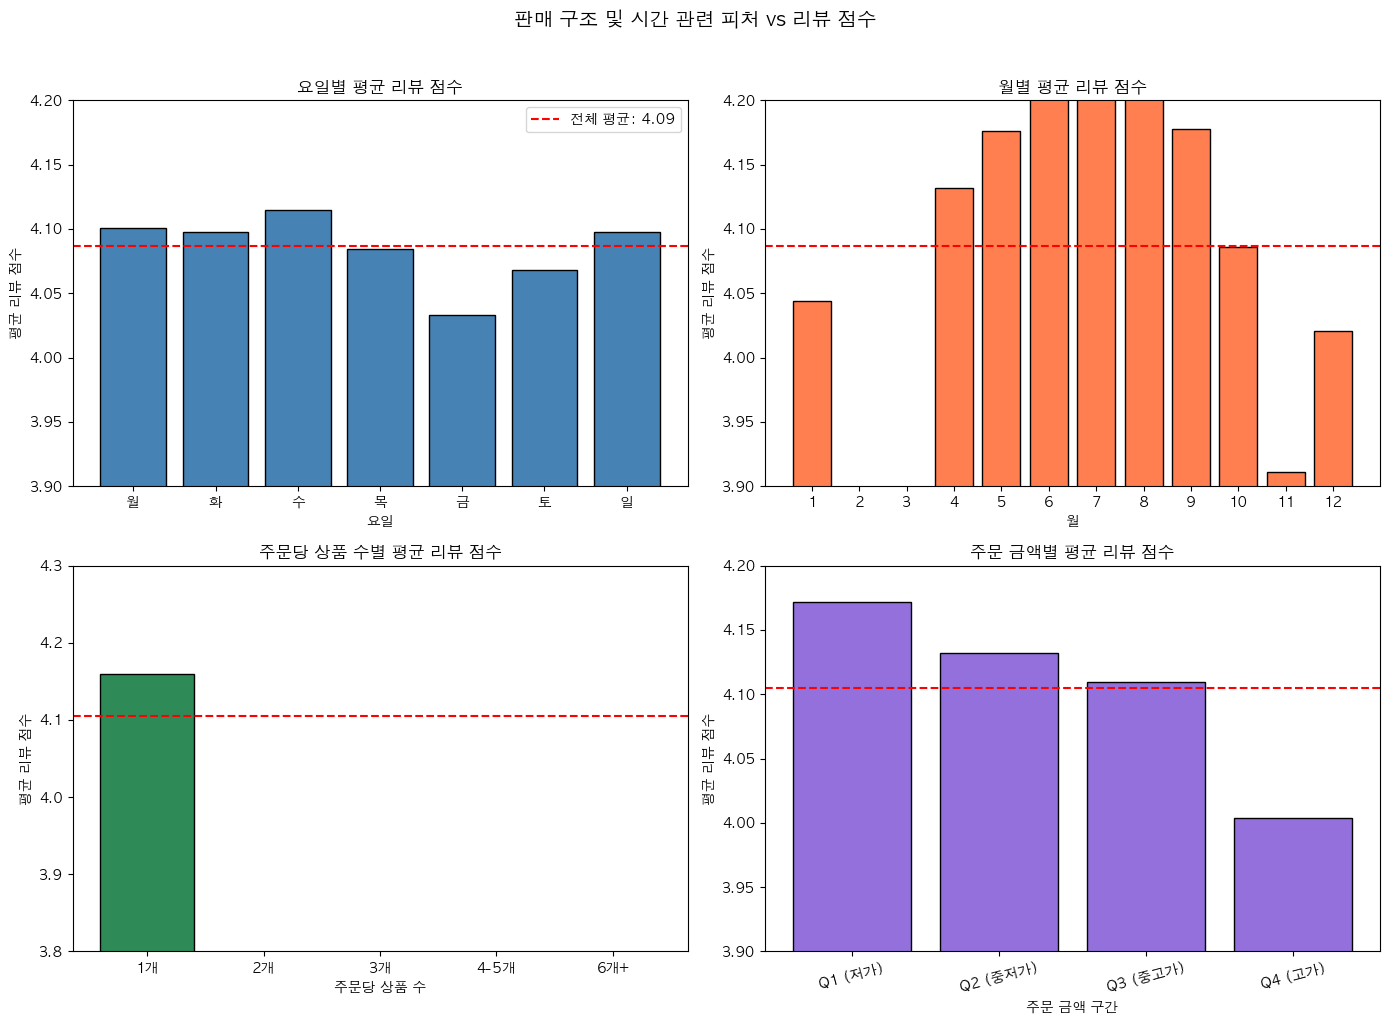

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 요일별 평균 리뷰 점수
ax = axes[0, 0]
ax.bar(day_stats['day_name'], day_stats['avg_score'], color='steelblue', edgecolor='black')
ax.axhline(y=time_review['review_score'].mean(), color='red', linestyle='--', 
           label=f'전체 평균: {time_review["review_score"].mean():.2f}')
ax.set_xlabel('요일')
ax.set_ylabel('평균 리뷰 점수')
ax.set_title('요일별 평균 리뷰 점수')
ax.set_ylim(3.9, 4.2)
ax.legend()

# 2. 월별 평균 리뷰 점수
ax = axes[0, 1]
ax.bar(month_stats['month'], month_stats['avg_score'], color='coral', edgecolor='black')
ax.axhline(y=time_review['review_score'].mean(), color='red', linestyle='--')
ax.set_xlabel('월')
ax.set_ylabel('평균 리뷰 점수')
ax.set_title('월별 평균 리뷰 점수')
ax.set_xticks(range(1, 13))
ax.set_ylim(3.9, 4.2)

# 3. 상품 수별 평균 리뷰 점수
ax = axes[1, 0]
ax.bar(item_stats['item_count'].astype(str), item_stats['avg_score'], color='seagreen', edgecolor='black')
ax.axhline(y=order_review['review_score'].mean(), color='red', linestyle='--')
ax.set_xlabel('주문당 상품 수')
ax.set_ylabel('평균 리뷰 점수')
ax.set_title('주문당 상품 수별 평균 리뷰 점수')
ax.set_ylim(3.8, 4.3)

# 4. 금액 구간별 평균 리뷰 점수
ax = axes[1, 1]
ax.bar(range(len(price_stats)), price_stats['avg_score'], color='mediumpurple', edgecolor='black')
ax.set_xticks(range(len(price_stats)))
ax.set_xticklabels(price_stats['price_bin'], rotation=15)
ax.axhline(y=order_review['review_score'].mean(), color='red', linestyle='--')
ax.set_xlabel('주문 금액 구간')
ax.set_ylabel('평균 리뷰 점수')
ax.set_title('주문 금액별 평균 리뷰 점수')
ax.set_ylim(3.9, 4.2)

plt.suptitle('판매 구조 및 시간 관련 피처 vs 리뷰 점수', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 판매 구조 및 시간 관련 피처 인사이트 요약

### 판매 구조 피처

| 피처 | EDA 결과 | ML 활용 가치 |
|------|----------|-------------|
| **상품 수** | 대부분 1개 상품 주문, 상품 수와 리뷰 상관관계 약함 | 약함 |
| **주문 금액** | 금액별 리뷰 점수 차이 미미 | 약함 |
| **판매자 수** | 대부분 단일 판매자, 분석 의미 제한적 | 제외 권장 |

### 시간 관련 피처

| 피처 | EDA 결과 | ML 활용 가치 |
|------|----------|-------------|
| **요일** | 요일별 점수 차이 0.01~0.02점 수준 | 약함 |
| **주말/평일** | 거의 차이 없음 | 제외 권장 |
| **월** | 월별 차이 있으나 계절 효과 불분명 | 약함 |
| **특수 기간** | 블랙프라이데이/크리스마스 시 부정 리뷰 증가 가능성 | 보통 |

### 핵심 발견

1. **판매 구조 피처의 영향은 미미**
   - 상품 수, 금액과 리뷰 점수의 상관관계가 매우 약함
   - 단일 상품 주문이 대다수 (분석 의미 제한)

2. **시간 피처도 영향이 약함**
   - 요일/시간대별 점수 차이가 0.01~0.02점 수준
   - 통계적으로 유의미한 차이라고 보기 어려움

3. **특수 기간만 고려 가치 있음**
   - 블랙프라이데이/크리스마스 시즌에 배송 지연 → 부정 리뷰 증가 가능
   - `is_holiday_season` 같은 단순 이진 피처로 활용 권장

### 결론

> 판매 구조와 시간 관련 피처는 리뷰 점수 예측에 **직접적인 영향이 약함**.
> 배송 관련 피처(동일 지역, 배송 시간)가 훨씬 중요한 예측 변수.
